In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from collections import Counter 
import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

sb.set(font_scale = 1.9)




#Functions for the this project

#data cleaning functions
def null_cleaning(data,columns):
    df =data
    for column in columns:
         df = df[df[column].notna()]
    return df

def value_cleaning(data, columns, value):
    df = data
    for column in columns:
        df = df[df[column] > value];
    return df

def outlier_cleaning(data, columns):
    df = data
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[column] < (Q1 - 1.5 * IQR)) |(df[column] > (Q3 + 1.5 * IQR)))]
    return df
        

#function for plotting top 10 most popular data
def plot_most_popular(data, region, base):
    publisher = data.groupby(base)[region].sum().reset_index()
    top_10 = publisher.nlargest(10,region)
    f = plt.figure(figsize= (50,10))
    #total sales
    sb.barplot(data=top_10, x=base, y=region, palette="dark")
    game_sales_scatter = data.loc[data[base].isin(top_10[base])]
    game_sales_scatter = game_sales_scatter[game_sales_scatter[region] > 0]
    f = plt.figure(figsize= (50,10))
    sb.boxplot(data=game_sales_scatter, x=base, y=region, palette="deep")

#function for top 5 games in each region
def top5_gamesByRegion(data, region):
    top_5 = data.nlargest(5, region)
    f = plt.figure(figsize= (30, 10))
    sb.barplot(data=top_5, x="Name",y=region, palette="dark")

#function for top 5 genres given region
def top5_genreByRegion(data, region):
    genre = data.groupby("Genre")[region].sum().reset_index()
    top_5 = genre.nlargest(5,region)
    f = plt.figure(figsize= (20,10))
    #total sales
    sb.barplot(data=top_5, x="Genre", y=region, palette="dark")
    game_sales_scatter = data.loc[data["Genre"].isin(top_5['Genre'])]
    print(game_sales_scatter.shape)
    game_sales_scatter = game_sales_scatter[game_sales_scatter[region] > 0]
    f = plt.figure(figsize= (20,10))
    sb.boxplot(data=game_sales_scatter, x="Genre", y=region, palette="deep")

#function to plot userscores given region
def userscore_region(data, region):
    userscore = pd.DataFrame(data["User_Score"])
    regionSales = pd.DataFrame(data[region])
    userscore_train, userscore_test, regionSales_train, regionSales_test = train_test_split(userscore, regionSales, test_size=0.2, random_state=42)
    trainDF = pd.concat([userscore_train, regionSales_train], axis = 1).reindex(userscore_train.index)
    sb.jointplot(data = trainDF, x = "User_Score", y = region, height = 12)
#function to plot criticscore given region
def cscore_region(data, region):
    cscore = pd.DataFrame(data["Critic_Score"])
    regionSales = pd.DataFrame(data[region])
    cscore_train, cscore_test, regionSales_train, regionSales_test = train_test_split(cscore, regionSales, test_size=0.2, random_state=42)
    trainDF = pd.concat([cscore_train, regionSales_train], axis = 1).reindex(cscore_train.index)
    sb.jointplot(data = trainDF, x = "Critic_Score", y = region, height = 12)
    
#Function for correlation heatmap of the data given region
def correlation(data, predictor, region):
    pred = pd.DataFrame(data[predictor])
    sales = pd.DataFrame(data[region])
    pred_train, pred_test, sales_train, sales_test = train_test_split(pred, sales, test_size=0.2, random_state=42)
    trainDF = pd.concat([pred_train, sales_train], axis = 1).reindex(pred_train.index)
    sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")
    
#Simple regression function 
def reg(data, sales, predictor):
    pred = pd.DataFrame(data[predictor])
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(pred,sales, test_size = 0.25, random_state=42)


    # Linear Regression using Train Data
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(X_train, y_train)        # train the linear regression model

    # Coefficients of the Linear Regression line
    print('Intercept of Regression \t: b = ', linreg.intercept_)
    print('Coefficients of Regression \t: a = ', linreg.coef_)
    print()

    # Predict Total values corresponding to HP
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    
  
    if(type(predictor) == str):
        plt.style.use('default')
        plt.style.use('ggplot')
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        ax.plot(X_train, y_train_pred, color='k', label='Regression model')
        ax.scatter(X_train, y_train, edgecolor='k', facecolor='grey', alpha=0.7, label=predictor)
        ax.set_ylabel('Global_Sales', fontsize=14)
        ax.set_xlabel(str(predictor), fontsize=14)
        ax.legend(facecolor='white', fontsize=11)
        ax.set_title('$R^2= %.2f$' % linreg.score(X_train, y_train), fontsize=18)
        fig.tight_layout()

    # Check the Goodness of Fit (on Train Data)
    print("For predictor "+ str(predictor)+":")
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()
    acc = linreg.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_test_pred)    
    return [str(predictor),acc, mse]

#simple regression model
def grad(data, sales, predictor):
    X = pd.DataFrame(data[predictor])
    y = sales
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)
    lasso = linear_model.Lasso()
    scores = cross_validate(lasso, X_train, y_train, cv=10,
                       scoring=('r2', 'neg_mean_squared_error'),
                       return_train_score=True)
    print("Cross validation: ",scores['train_r2'])
    reg = GradientBoostingRegressor(random_state=42)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    y_test_pred= reg.predict(X_test)
    acc = reg.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_test_pred)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", acc)
    print("Mean Squared Error (MSE) \t:", mse)
    print()
    
    return [str(predictor),acc, mse]

#model function for goodness of fit
def fit_and_eval(data, predictor, sale, model):
    sales = pd.DataFrame(data[sale])
    pred = pd.DataFrame(data[predictor])
    # Split the Dataset into Train and Test
    pred_train, pred_test, sales_train, sales_test = train_test_split(pred,sales, test_size = 0.25, random_state=42)
    
    # Train the model
    model.fit(pred_train, sales_train)
    
    # Make predictions and evalute
    model_pred = model.predict(pred_train)
    
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", model.score(pred_train, sales_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(sales_train, model_pred))


    

# **Let's check out the dataset first**

In [2]:
data = pd.read_csv('/kaggle/input/video-game-sales-with-ratings/Video_Games_Sales_as_at_22_Dec_2016.csv')
data

Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

          Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  \
0          Nintendo     41.36     28.96      3.77         8.45         82.53   
1          Nintendo     29.08      3.58      6.81         0.77         40.24   
2          Nintendo     15.68     12.76      3.79         3.29         35.52   
3          Nintendo     15.61     10.93      3.28         2.95         32.77   
4          Nintendo     11.27      8.89     10.22         1.00         31.37   
...             ...       ...       ...       ...          ...           ...   
16714    Tecmo Koei      0.00      0.00      0.01         0.00          0.01   
16715   Codemasters      0.00      0.01      0.00         0.00          0.01   
16716  Idea Factory      0.00      0.00      0.01         0.00          0.01   
16717       Wanadoo      0.01      0.00      0.00         0.00          0.01   
16718    Tecmo Koei      0.00      0.00      0.01         0.00          0.01   

       Critic_Score  Critic_Count User_Score  User_Count Developer Rating  
0              76.0          51.0          8       322.0  Nintendo      E  
1               NaN           NaN        NaN         NaN       NaN    NaN  
2              82.0          73.0        8.3       709.0  Nintendo      E  
3              80.0          73.0          8       192.0  Nintendo      E  
4               NaN           NaN        NaN         NaN       NaN    NaN  
...             ...           ...        ...         ...       ...    ...  
16714           NaN           NaN        NaN         NaN       NaN    NaN  
16715           NaN           NaN        NaN         NaN       NaN    NaN  
16716           NaN           NaN        NaN         NaN       NaN    NaN  
16717           NaN           NaN        NaN         NaN       NaN    NaN  
16718           NaN           NaN        NaN         NaN       NaN    NaN  

[16719 rows x 16 columns]

**Checking how many valid values are there**

In [3]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

Missing Ratio
User_Count           54.602548
Critic_Score         51.330821
Critic_Count         51.330821
Rating               40.486871
User_Score           40.098092
Developer            39.613613
Year_of_Release       1.608948
Publisher             0.322986
Name                  0.011962
Genre                 0.011962

 # **Basic EDA**

Corr heatmap for all the data 

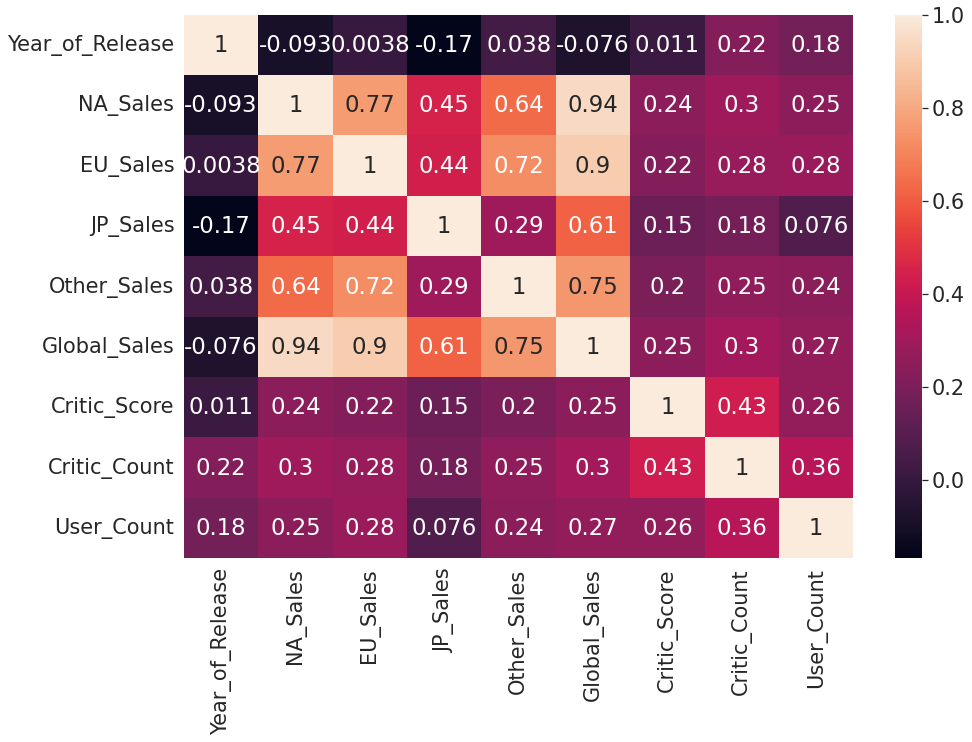

In [4]:
plt.figure(figsize=(15, 10))
data_corr = data.corr()
sb.heatmap(data_corr, 
            xticklabels = data_corr.columns.values,
            yticklabels = data_corr.columns.values,
            annot = True);

Generally, Sales have weak correlations with all the numerical variables other than dependent variables(region sales). Hence let's explore some of the catergorical variables first.

Let's start by looking at the top 5 games in each region:

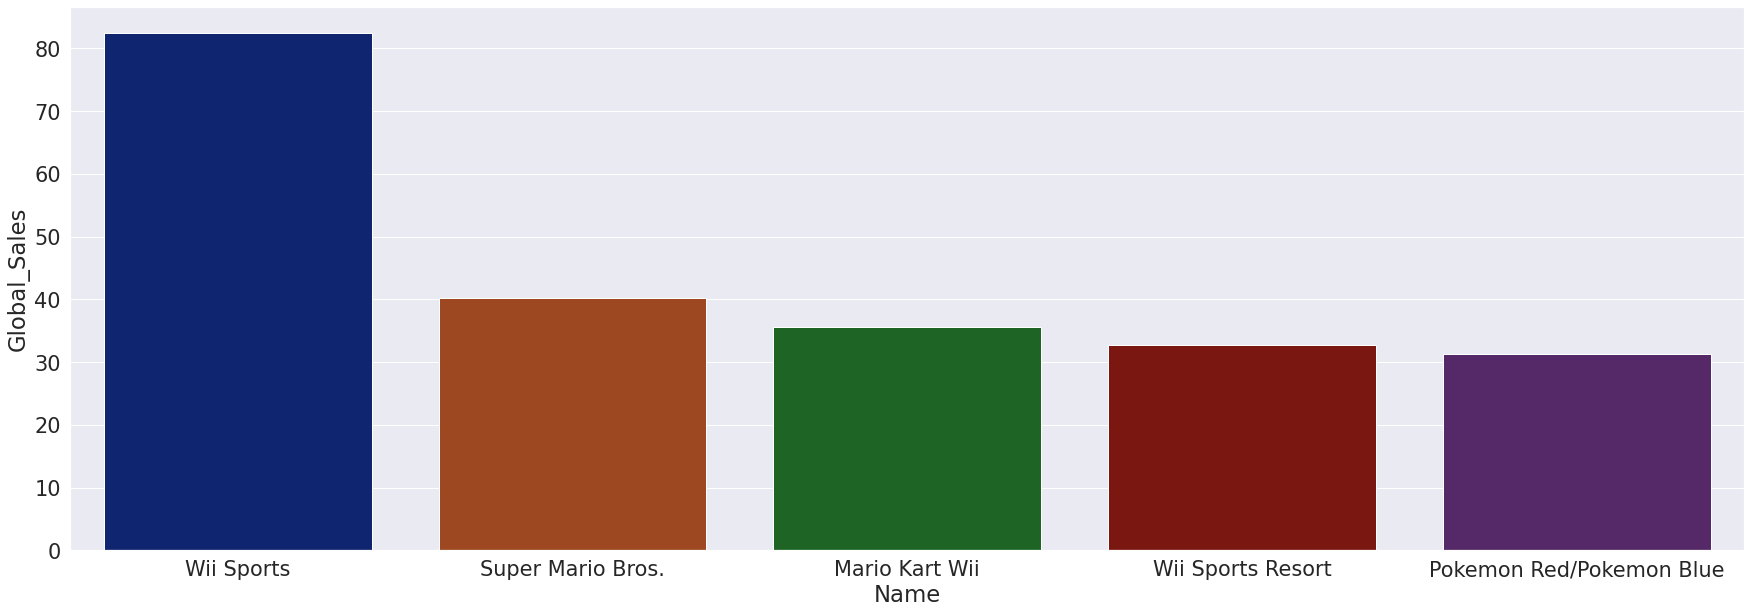

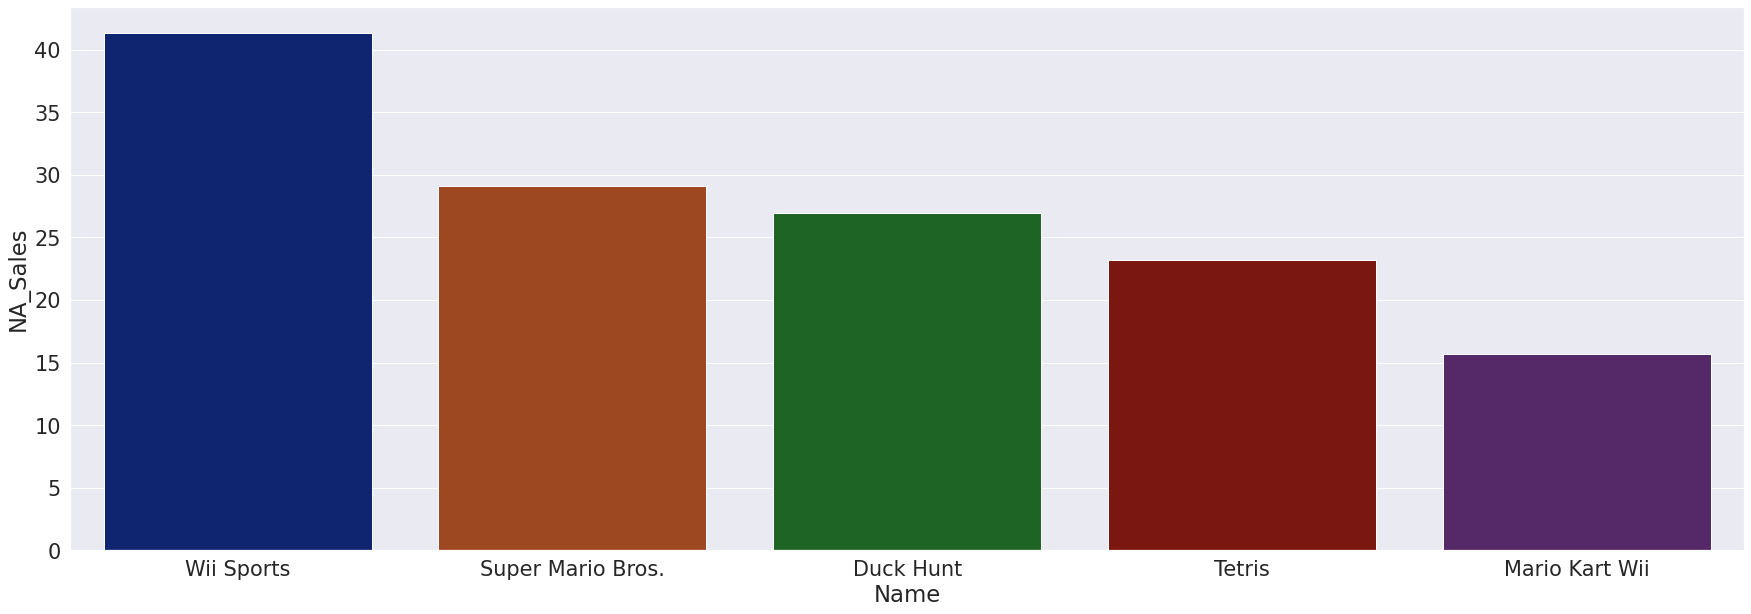

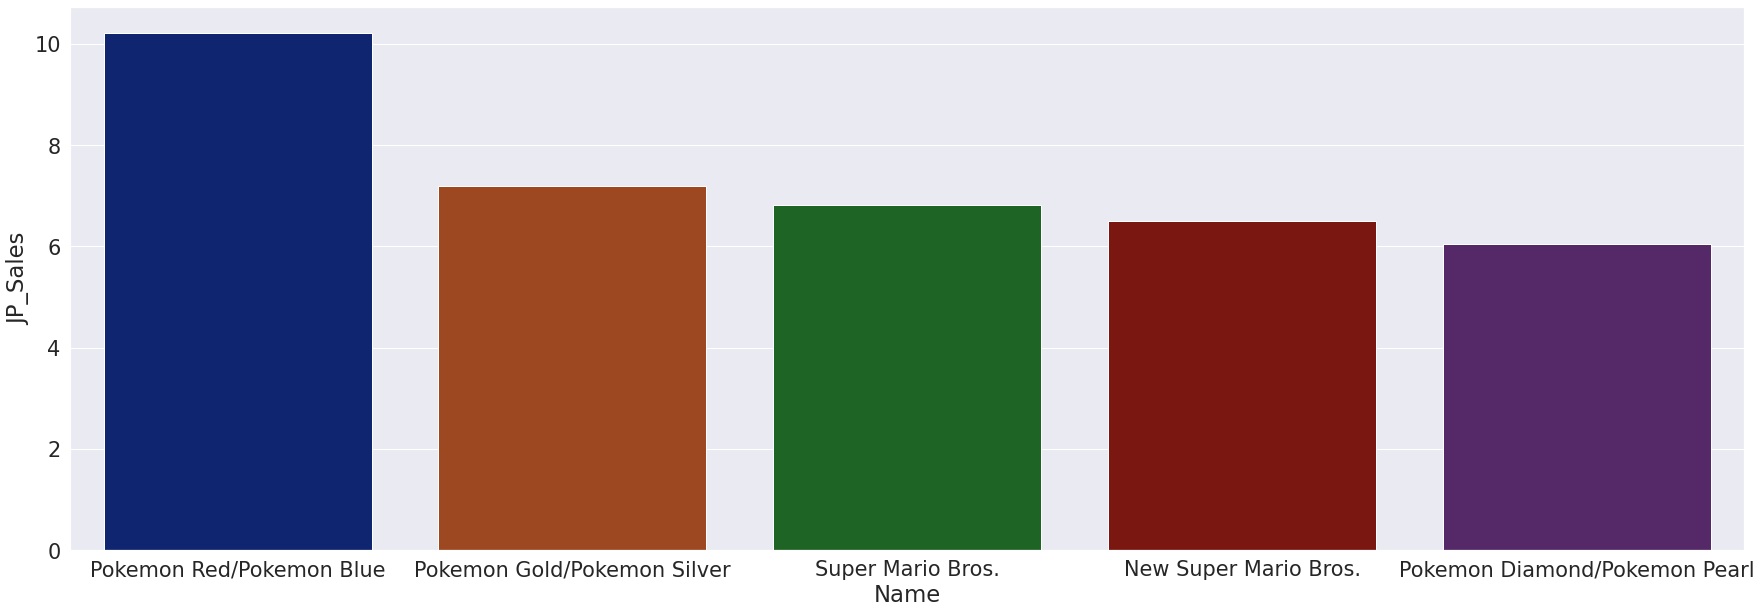

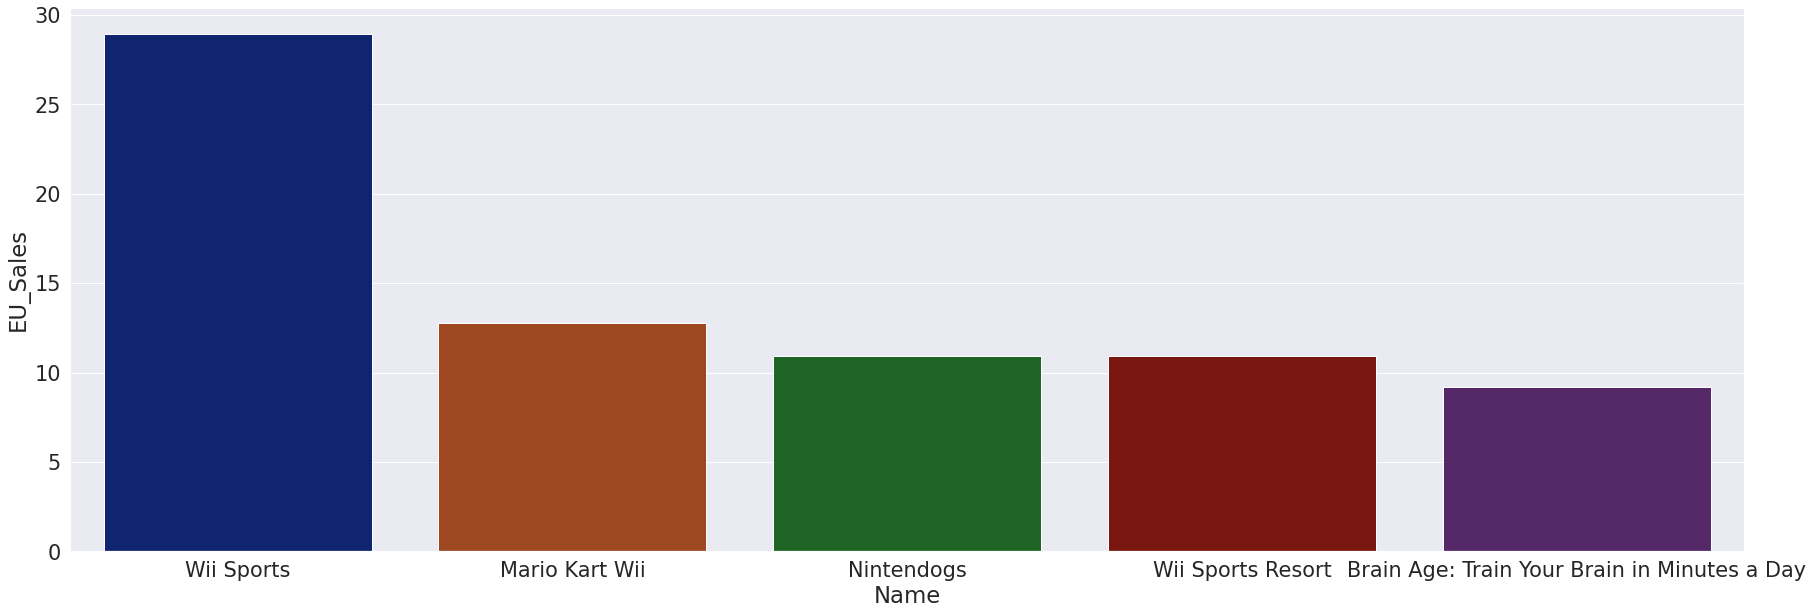

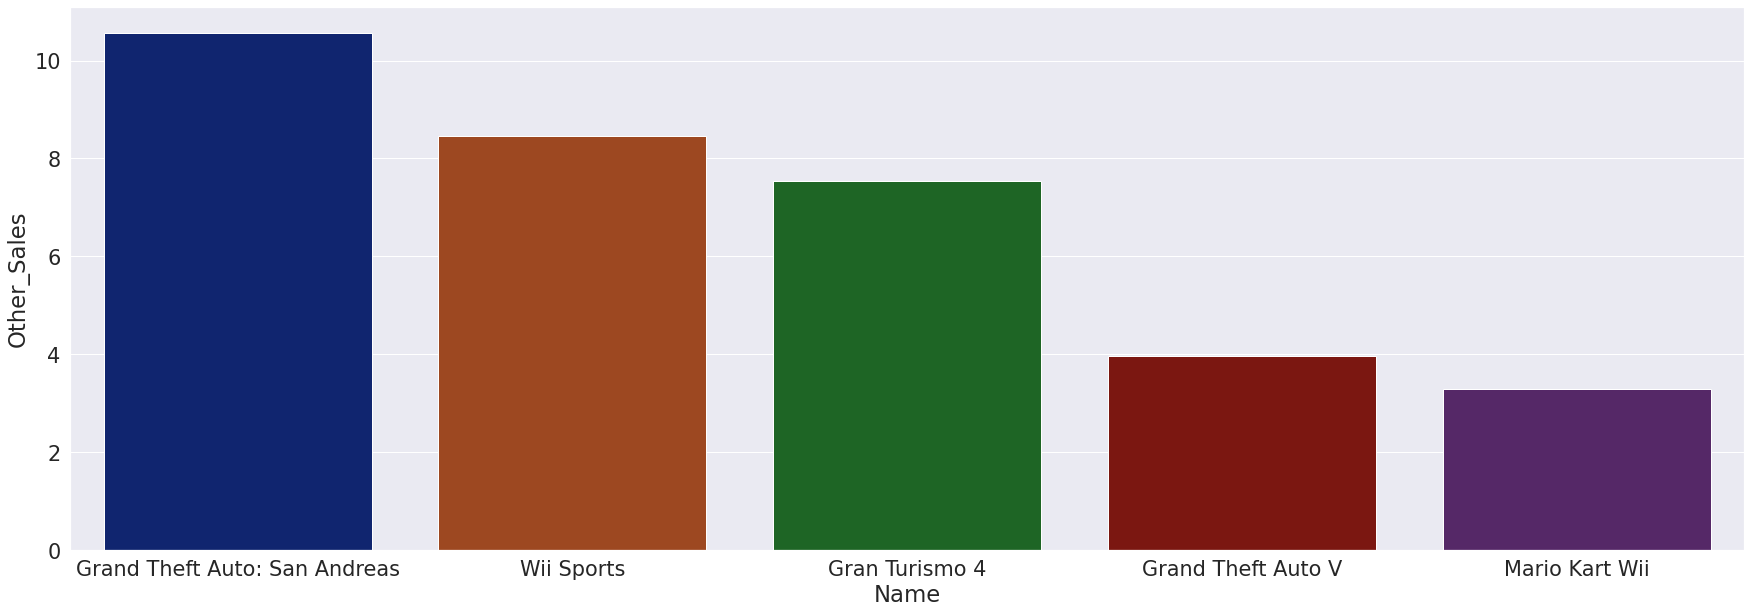

In [5]:
top5_gamesByRegion(data, "Global_Sales")
top5_gamesByRegion(data, "NA_Sales")
top5_gamesByRegion(data, "JP_Sales")
top5_gamesByRegion(data, "EU_Sales")
top5_gamesByRegion(data, "Other_Sales")

Interestly, Every region has different top 5s. Every region has a slight difference in taste. NA sales also make up a huge proportion of the Global Sales and followed by EU sales.

# **1. Genre**

**Data Cleaning before EDA**

In [6]:
cleanedData = null_cleaning(data, ['Genre', 'Publisher'])
cleanedGenre = cleanedData['Genre'] 


Plotting the graphs to see some relationships

Text(0.5, 1.0, 'Global Video Game Sales')

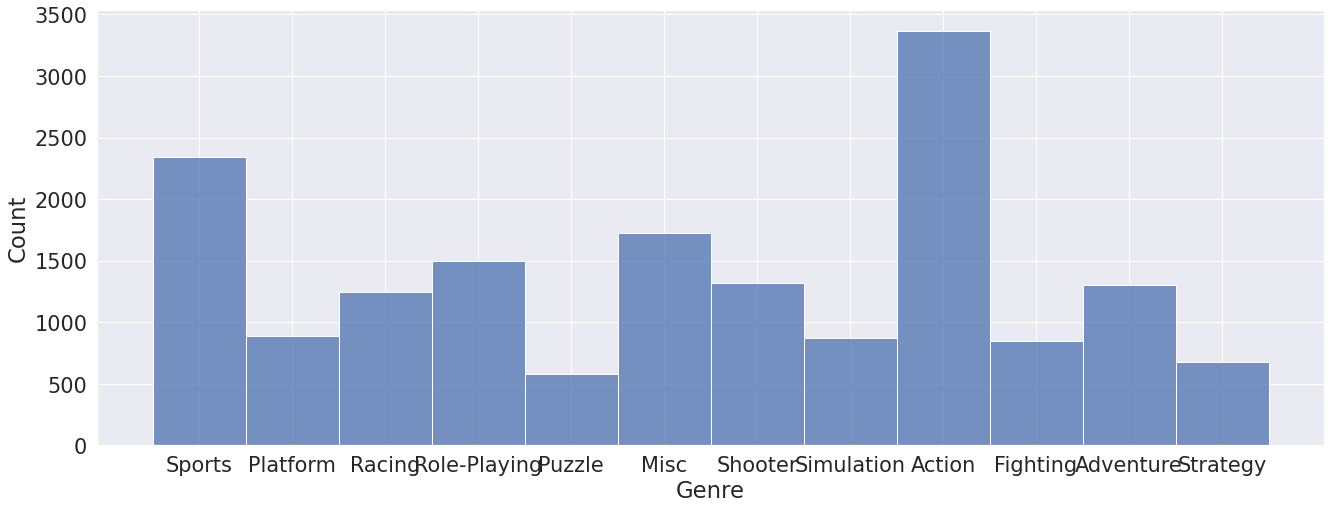

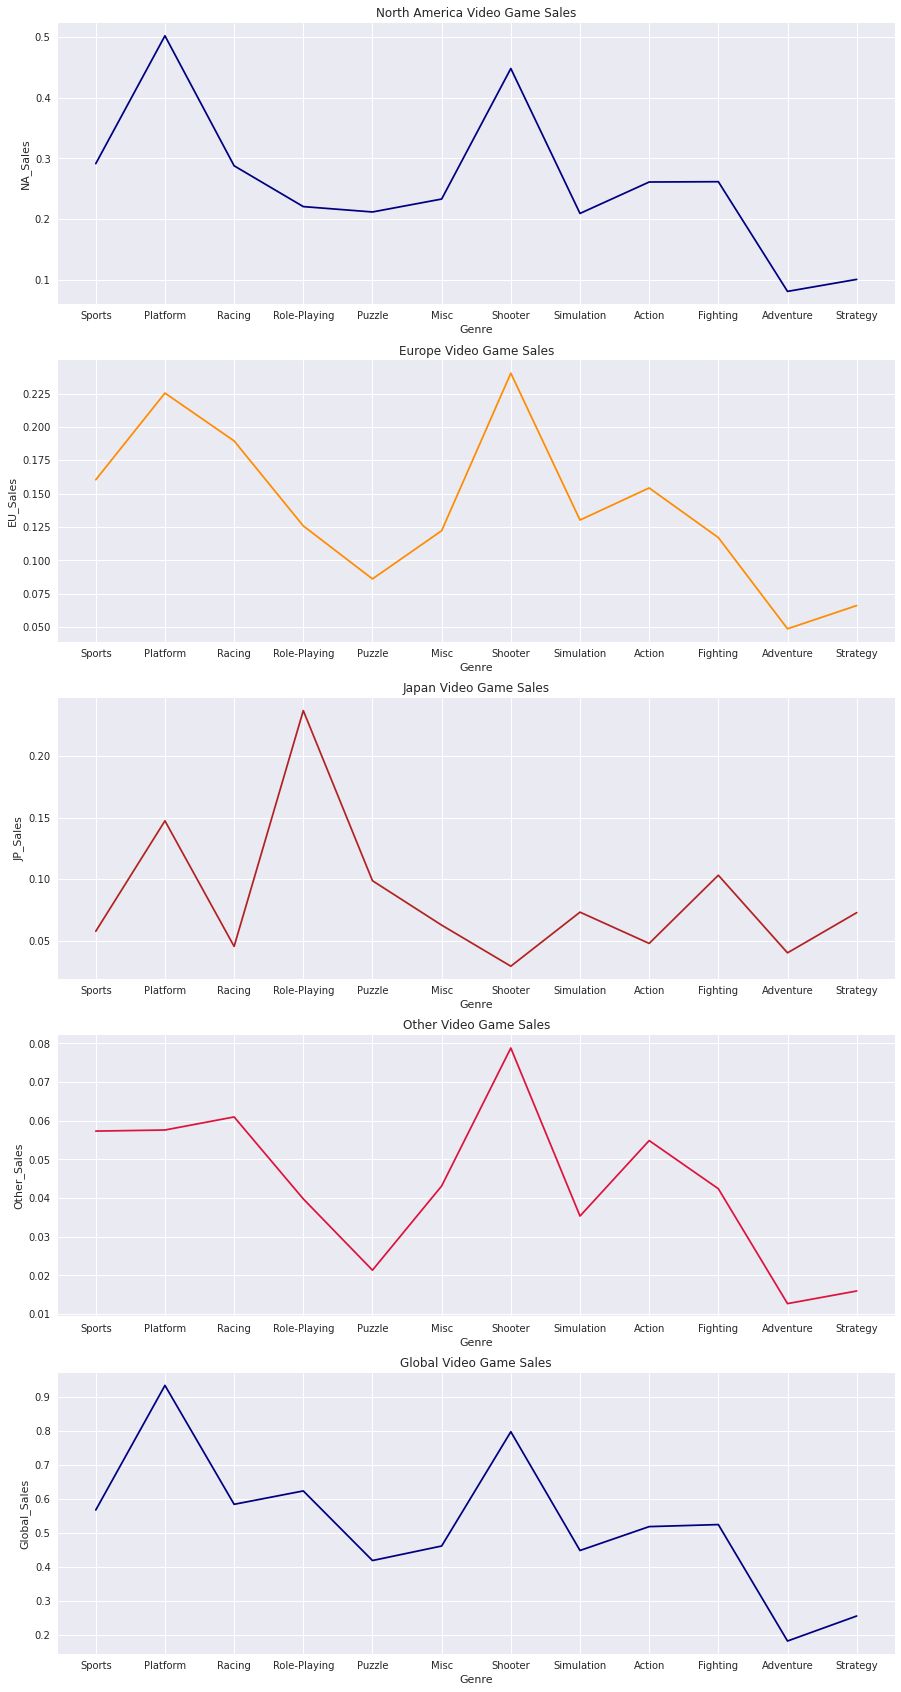

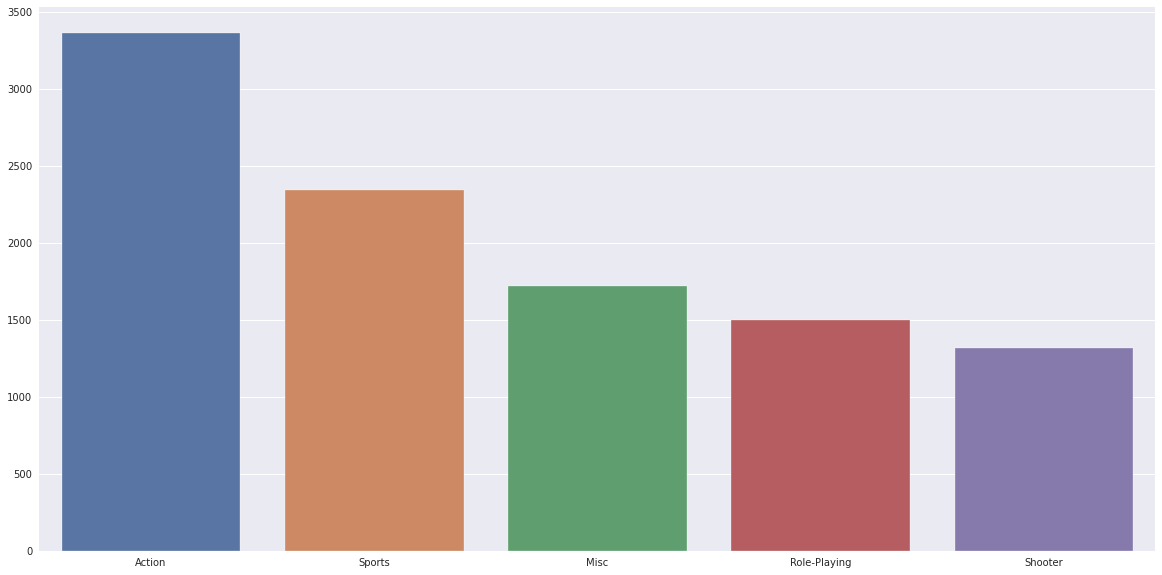

In [7]:
fig, ax = plt.subplots(1,1, figsize=(22,8))
sb.histplot(data = cleanedGenre)

plt.style.use("seaborn")
fig, ax =plt.subplots(5,1, figsize=(15,30)) 

top_5 = Counter(cleanedData['Genre'].tolist()).most_common(5)
top_x, top_y = [x[0] for x in top_5], [x[1] for x in top_5]
f = plt.figure(figsize= (20,10))
sb.barplot(x=top_x,y=top_y, palette="deep")

sb.lineplot(data=cleanedData, x = 'Genre', y = "NA_Sales", ci=None, ax=ax[0], color="navy")
ax[0].set_title("North America Video Game Sales")

sb.lineplot(data=cleanedData, x = 'Genre', y = "EU_Sales", ci=None, ax=ax[1], color="darkorange")
ax[1].set_title("Europe Video Game Sales")

sb.lineplot(data=cleanedData, x = 'Genre', y = "JP_Sales", ci=None, ax=ax[2], color="firebrick")
ax[2].set_title("Japan Video Game Sales")

sb.lineplot(data=cleanedData, x = 'Genre', y = "Other_Sales", ci=None, ax=ax[3], color="crimson")
ax[3].set_title("Other Video Game Sales")

sb.lineplot(data=cleanedData, x = 'Genre', y = "Global_Sales", ci=None, ax=ax[4], color="navy")
ax[4].set_title("Global Video Game Sales")


The Bar graph shows us the total number of games released under each genre. With action taking the lead.
From the line graphs we can identify the top genre in each region easily by the sales in that region:

1. Top North American Genre: Platform
2. Top Europe Genre: Shooter
3. Top Japan Genre: Role-Playing 
4. Top Global Genre: platform
5. Top Genre for Other Region: Shooter

(9640, 16)
(10001, 16)
(9818, 16)
(10001, 16)
(9416, 16)


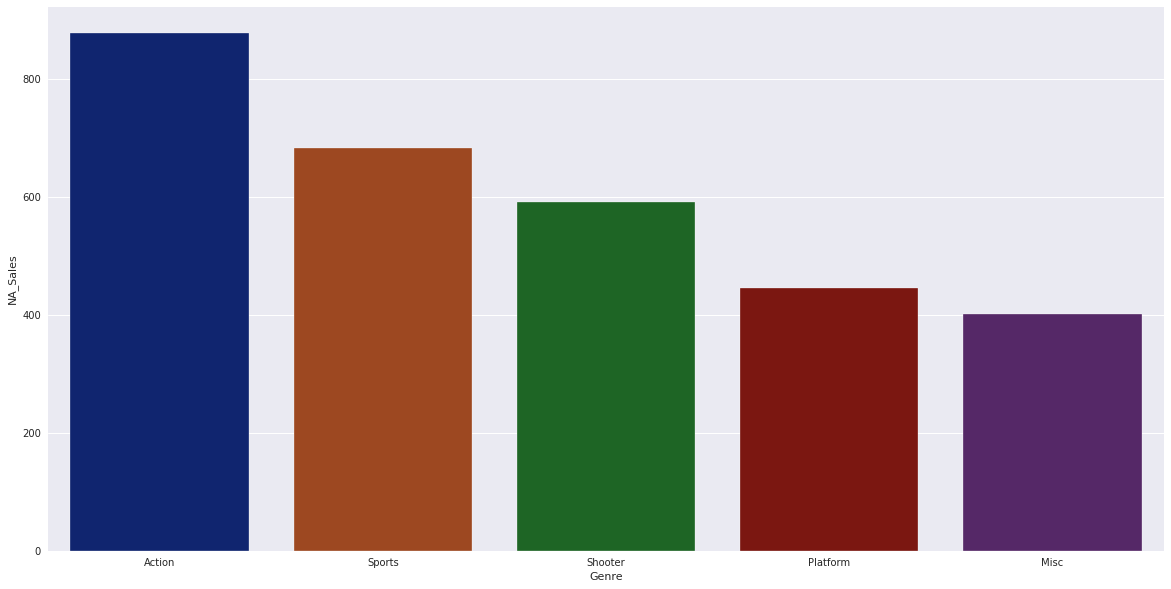

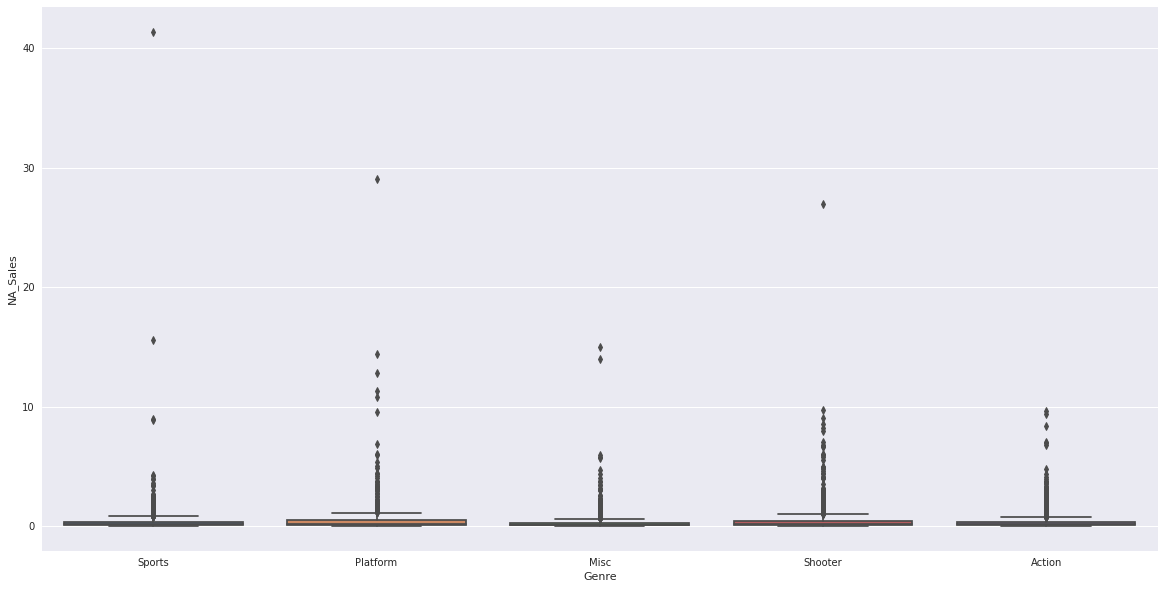

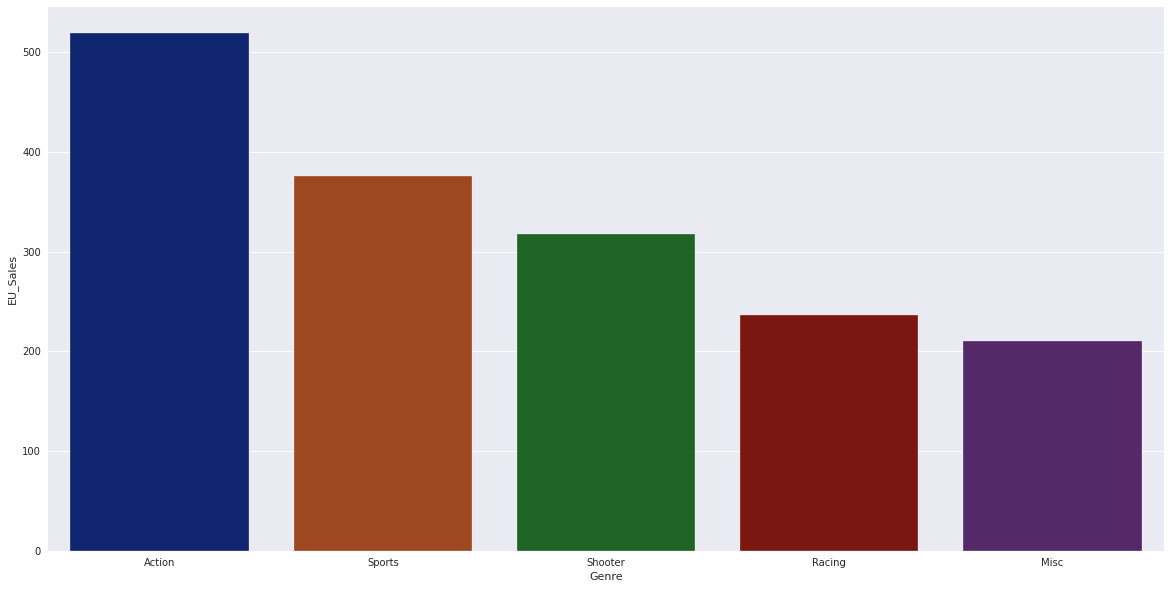

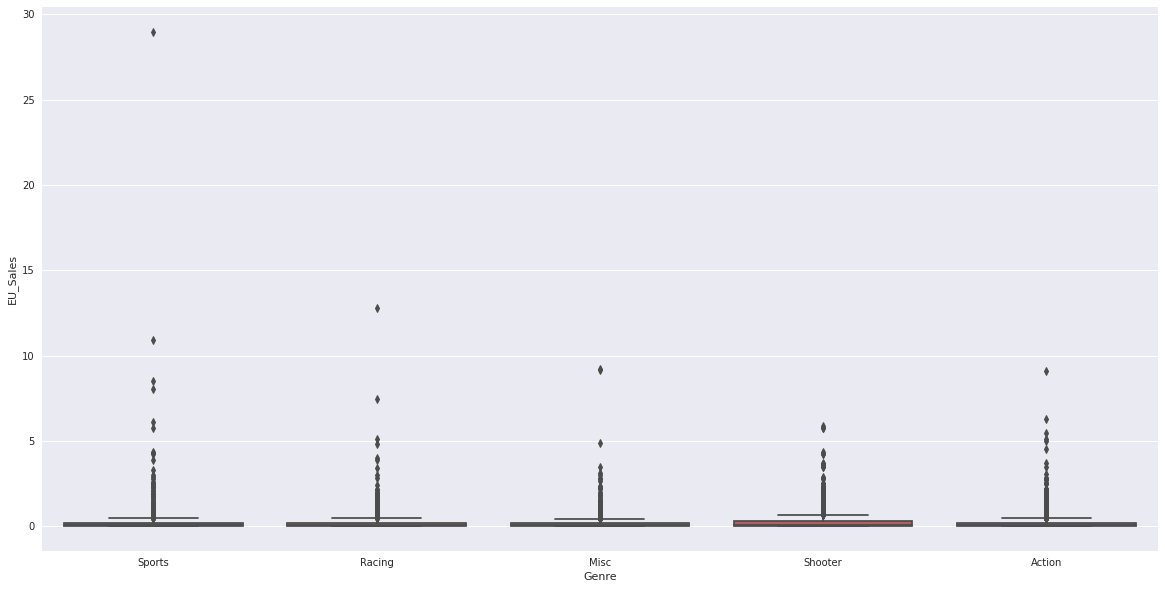

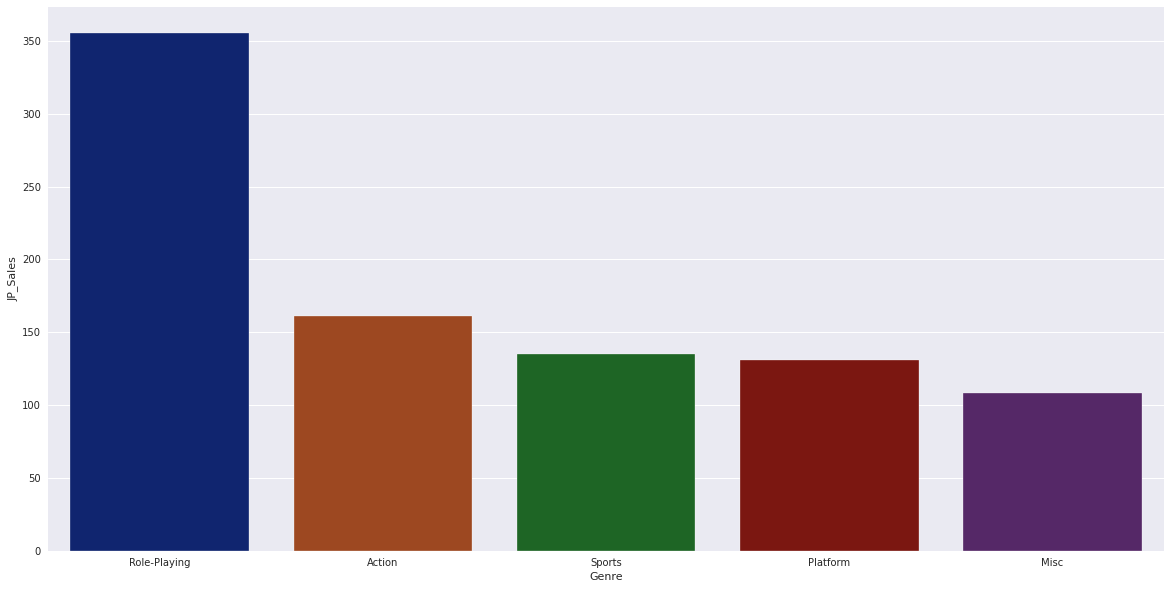

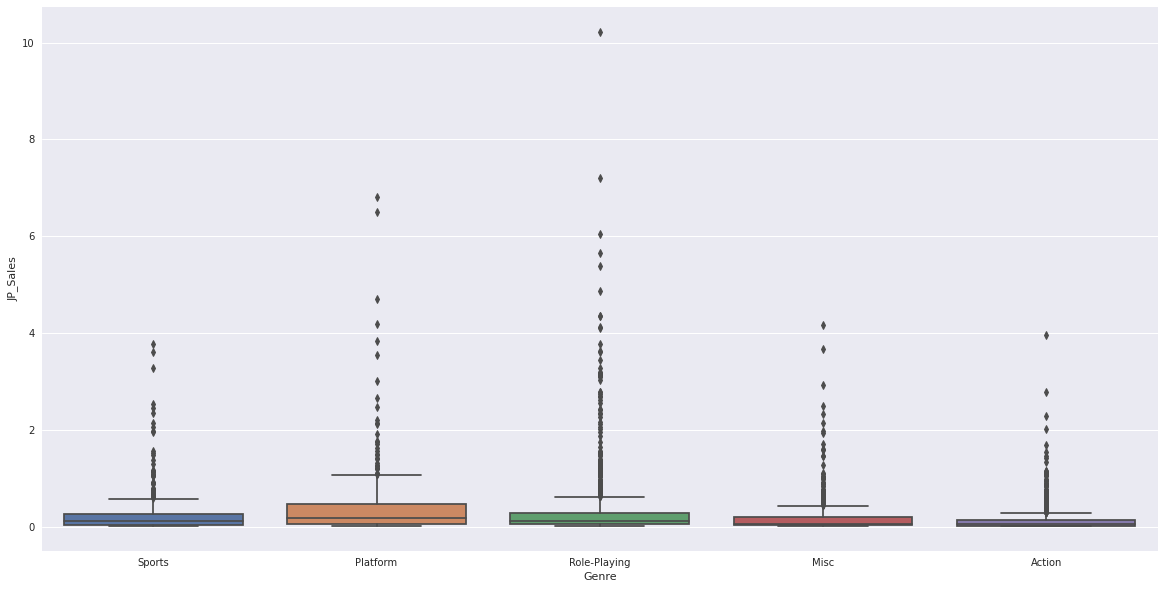

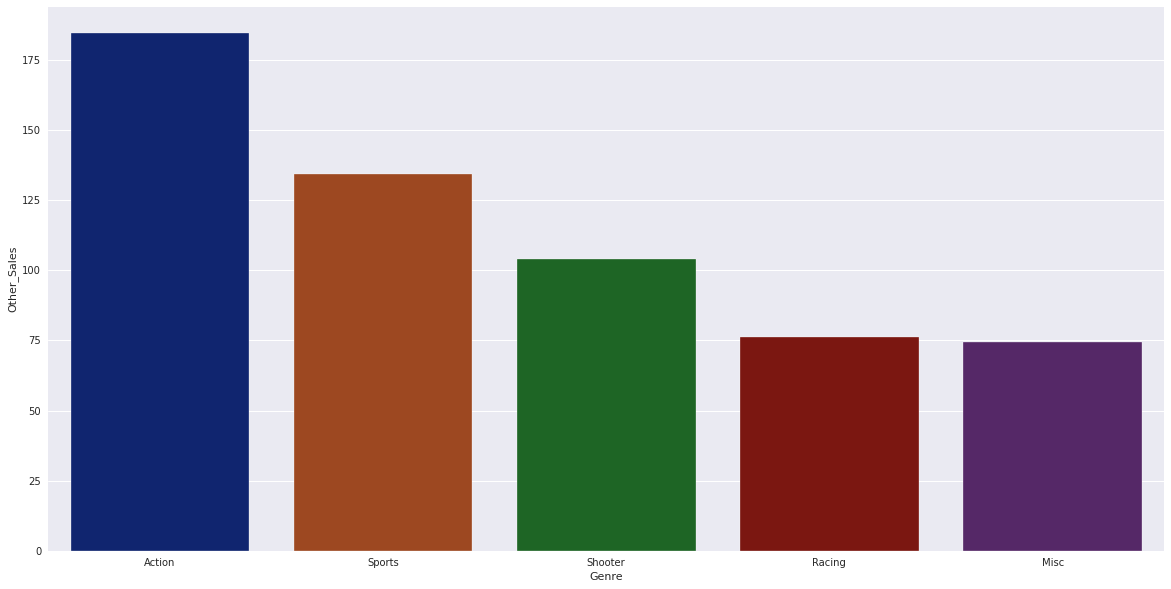

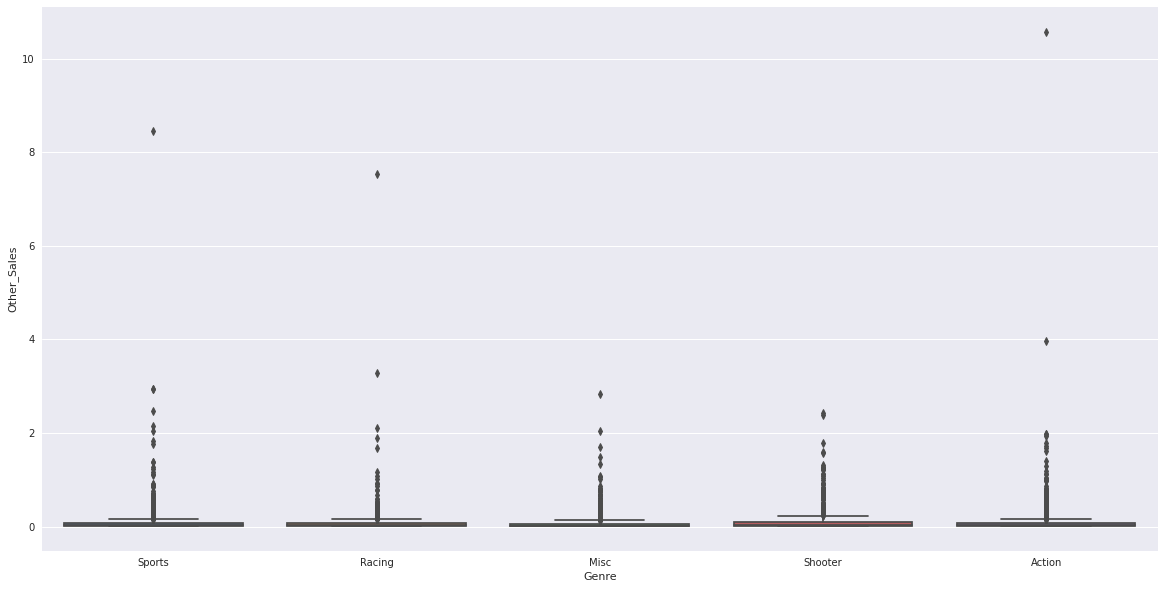

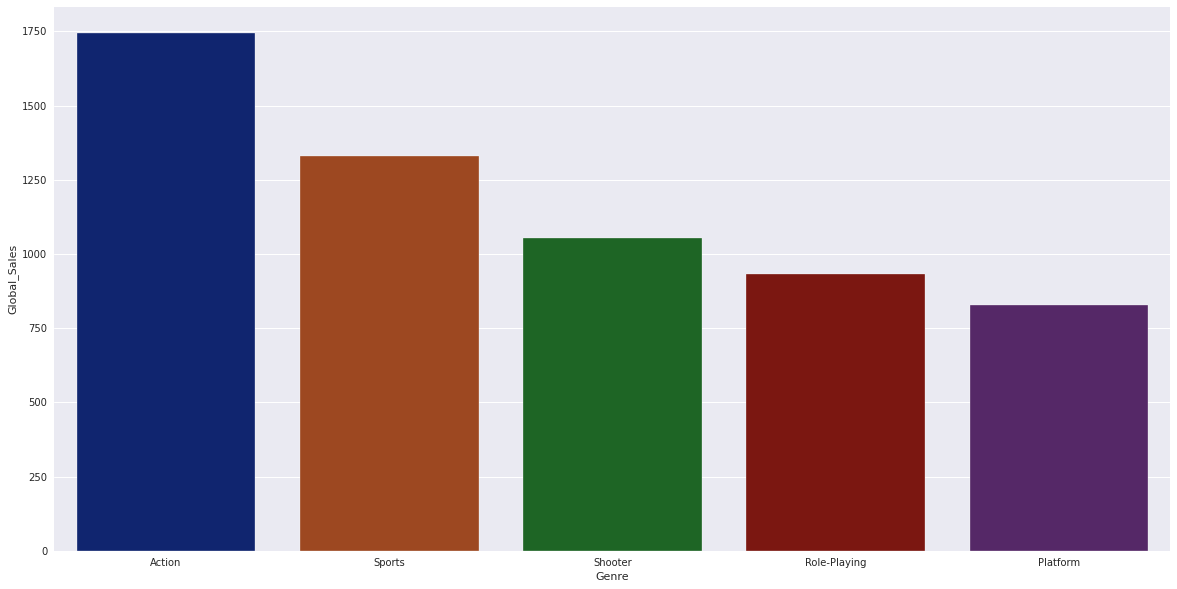

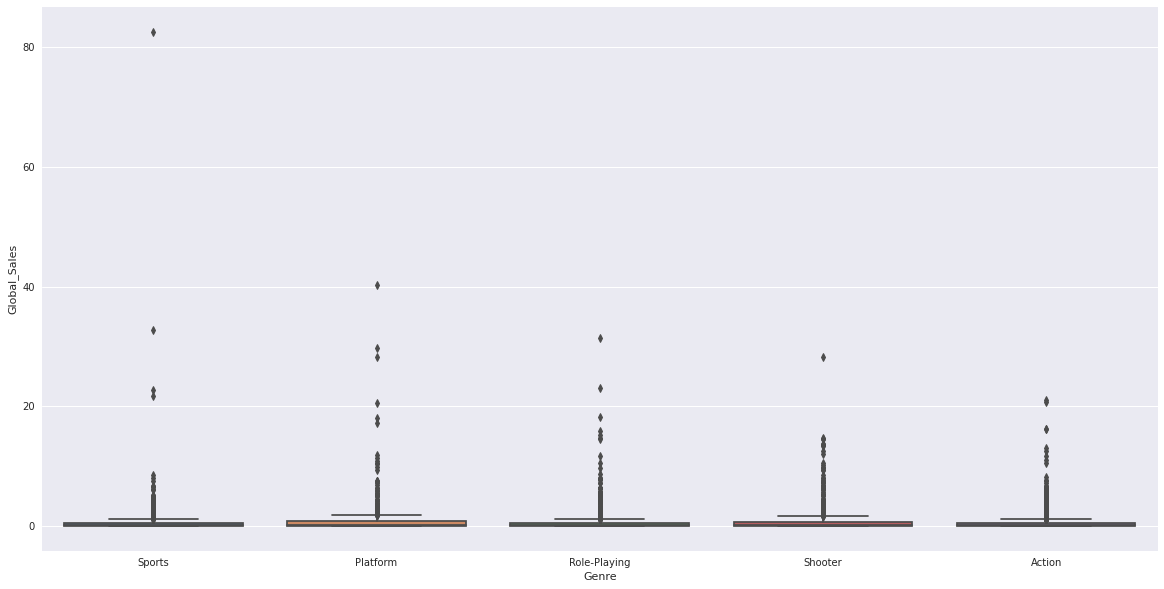

In [8]:
#from each region pick the top 5
top5_genreByRegion(cleanedData,"NA_Sales")

top5_genreByRegion(cleanedData,"EU_Sales")

top5_genreByRegion(cleanedData,"JP_Sales")

top5_genreByRegion(cleanedData,"Other_Sales")

top5_genreByRegion(cleanedData,"Global_Sales")

Numerical bar graph for top 5 genre in each region by the number of release. Interestingly, for most regions, action games has the highest number of releases but still did not top in sales. We can also observe a lot of outliers.

# **2. Platform**

Data cleaning before EDA.

In [9]:
cleanedData = null_cleaning(data, ['Platform'])



Lets see the games released by the different platforms

<AxesSubplot:title={'center':'Global_Sales'}, ylabel='Platform'>

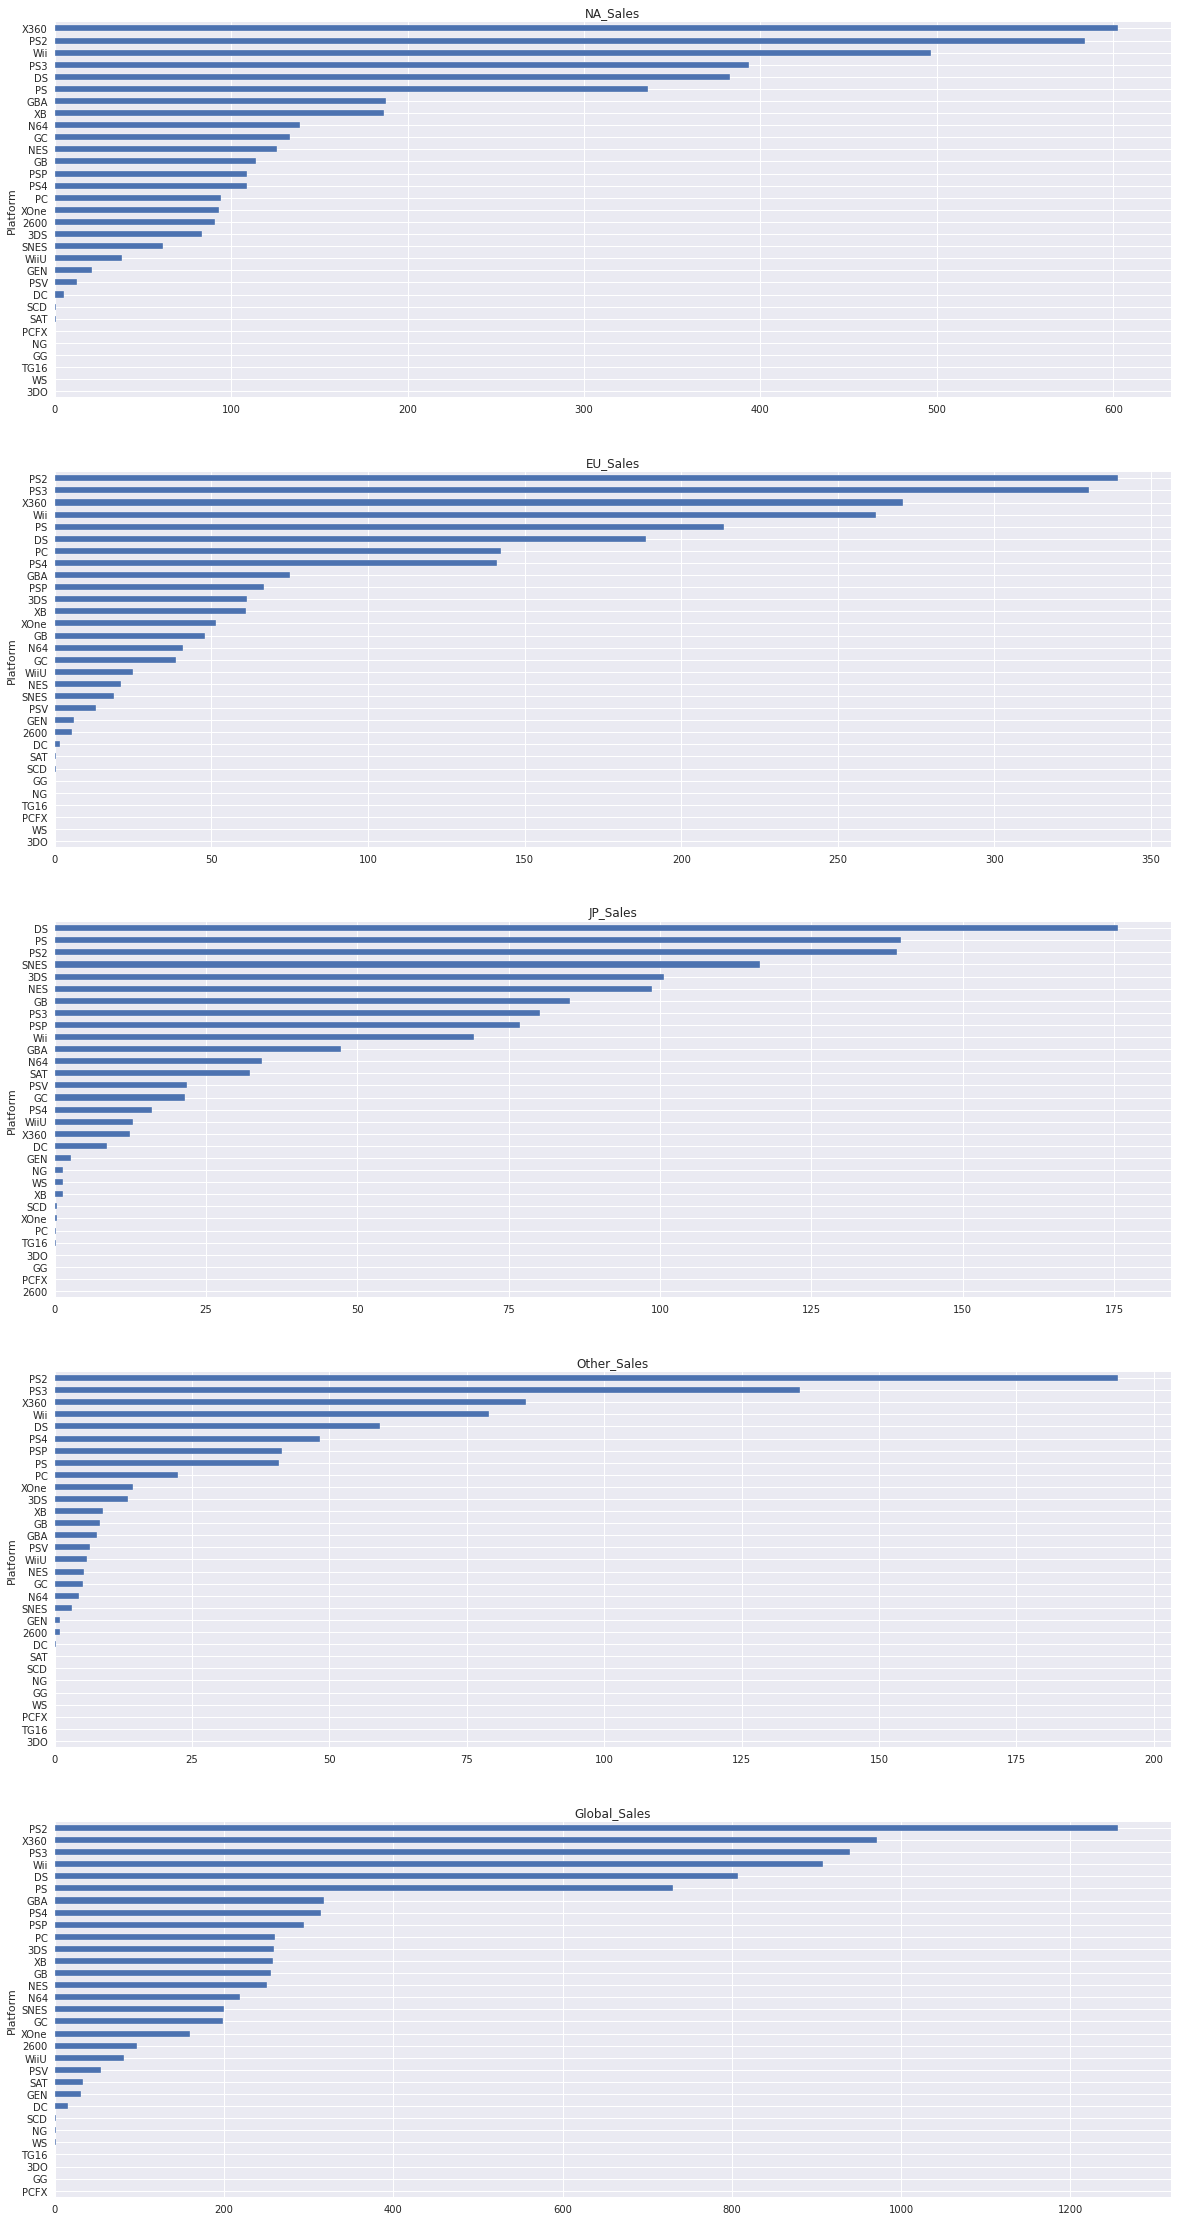

In [10]:
f, axes = plt.subplots(5, 1, figsize=(20, 40))
cleanedData.groupby('Platform')['NA_Sales'].sum().sort_values(ascending=True).plot(kind='barh', title='NA_Sales', ax = axes[0])
cleanedData.groupby('Platform')['EU_Sales'].sum().sort_values(ascending=True).plot(kind='barh', title='EU_Sales', ax = axes[1])
cleanedData.groupby('Platform')['JP_Sales'].sum().sort_values(ascending=True).plot(kind='barh', title='JP_Sales', ax = axes[2])
cleanedData.groupby('Platform')['Other_Sales'].sum().sort_values(ascending=True).plot(kind='barh', title='Other_Sales', ax = axes[3])
cleanedData.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=True).plot(kind='barh', title='Global_Sales', ax = axes[4])

Generally, PS2 and X360 games have the greatest number of sales in each region with the exception of the Japan region(DS). Maybe in Japan, handhelds are more popuplar?


# **3. Publisher**

Cleaning data

In [11]:
#checking invalid data rows
print(data["Publisher"].isnull().sum());
print(data[["NA_Sales","EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]].isnull().sum())
#simple cleaning
cleaned_data = null_cleaning(data, ["Publisher"])
print(cleaned_data["Publisher"].value_counts())

54
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64
Electronic Arts                 1356
Activision                       985
Namco Bandai Games               939
Ubisoft                          933
Konami Digital Entertainment     834
                                ... 
Valve                              1
ITT Family Games                   1
Elite                              1
Evolution Games                    1
Red Flagship                       1
Name: Publisher, Length: 581, dtype: int64


Finding the top 10 publishers

<AxesSubplot:>

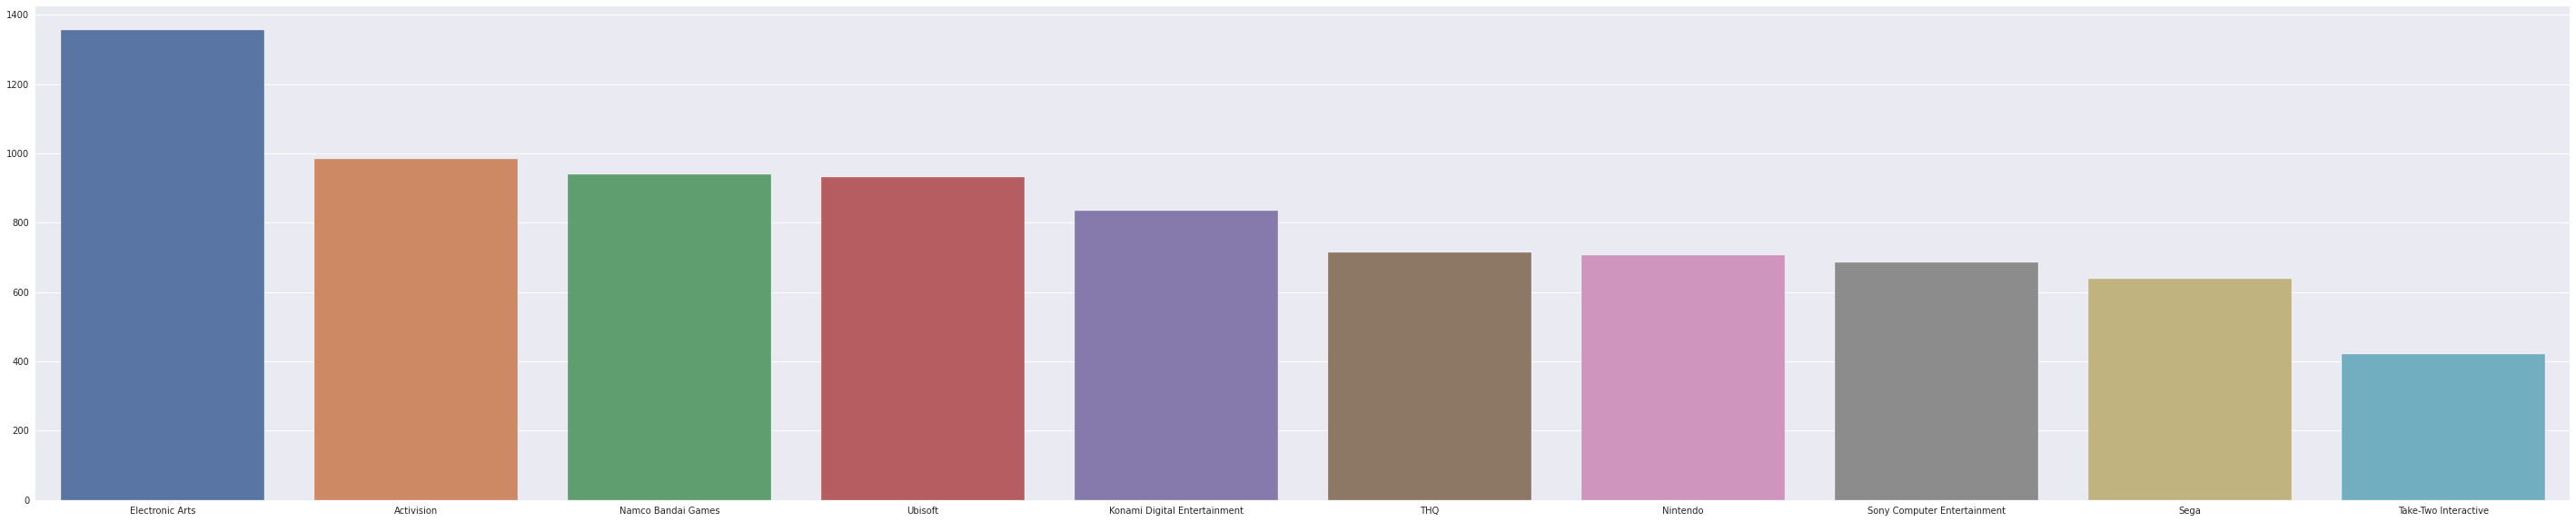

In [12]:
#top 10 publishers with the most number of games
top_10 = Counter(cleaned_data['Publisher'].tolist()).most_common(10)
top_x, top_y = [x[0] for x in top_10], [x[1] for x in top_10]
f = plt.figure(figsize= (50,10))
sb.barplot(x=top_x,y=top_y, palette="deep")

Obviously the AAA publishers have the highest number of games released. Let's now take a look at publishers with the most sales in each region. 

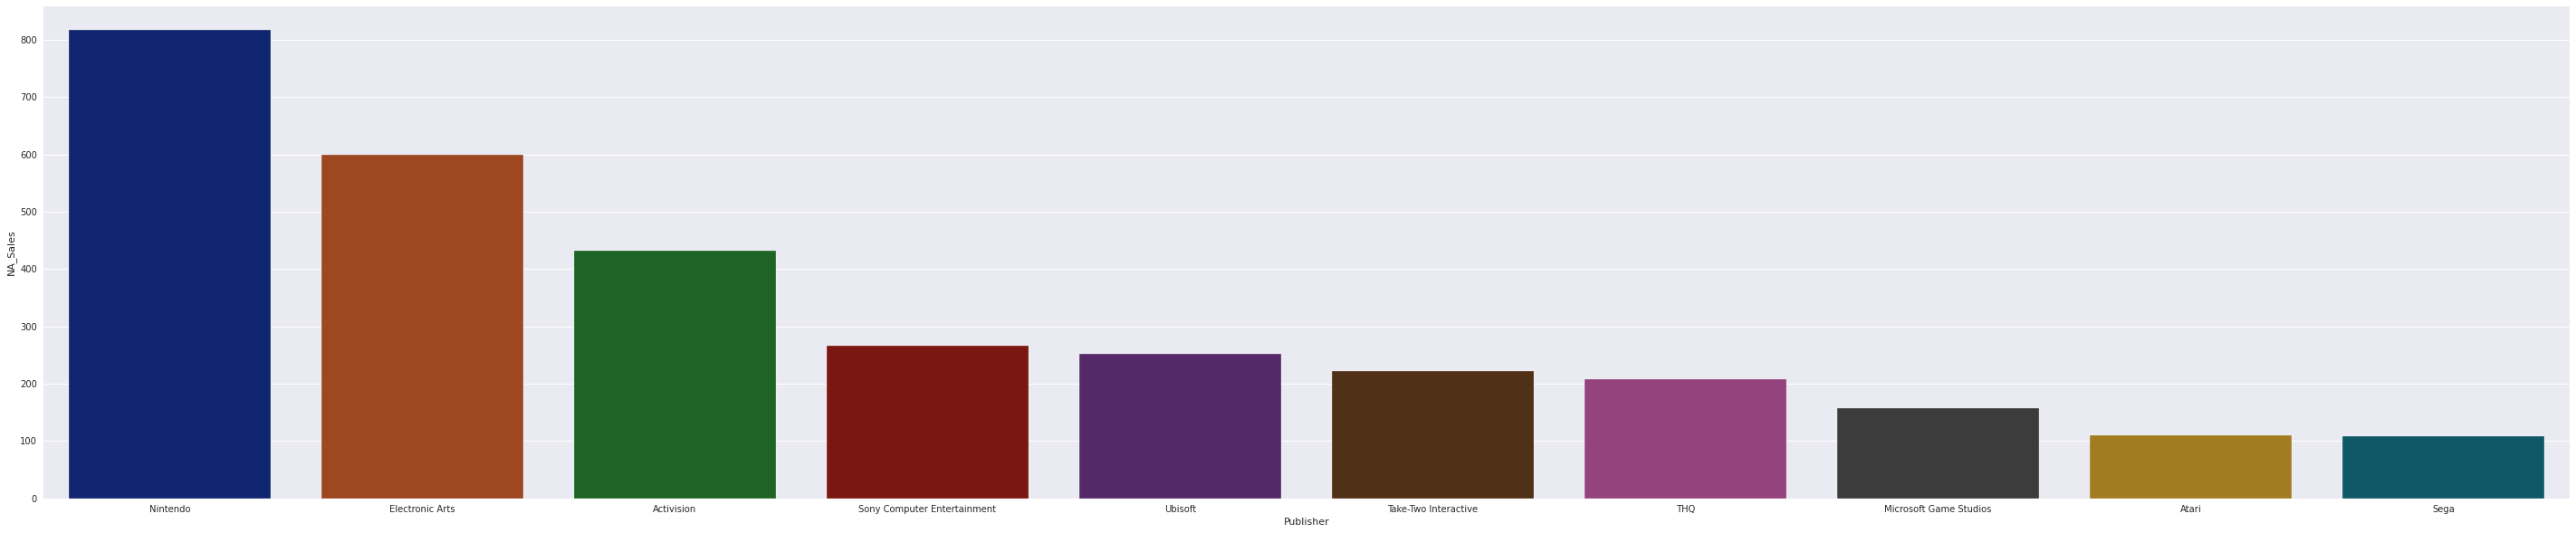

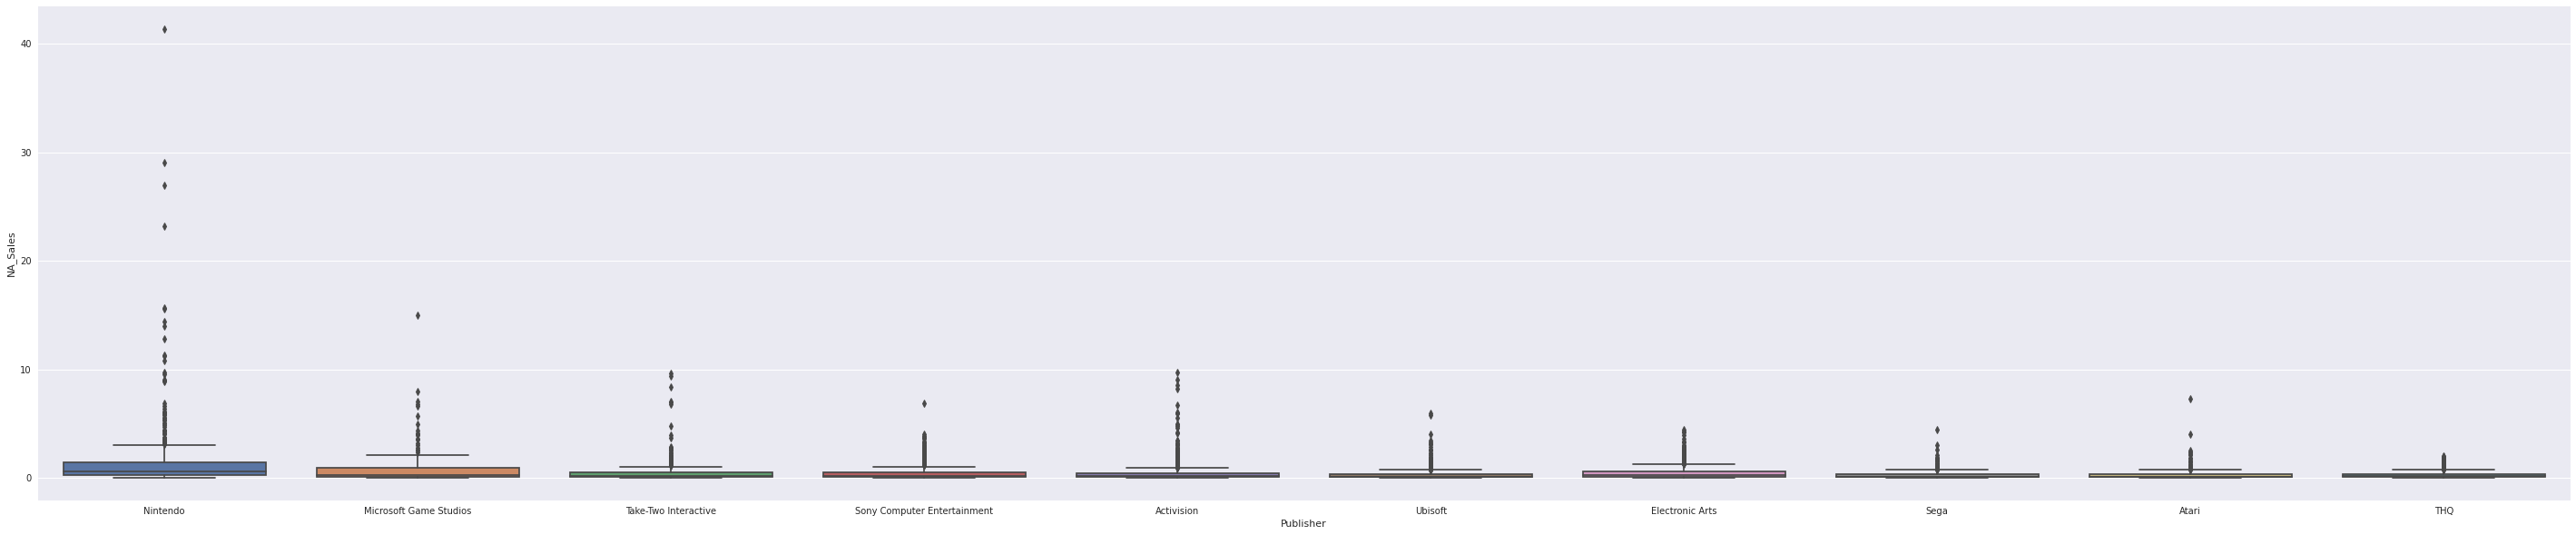

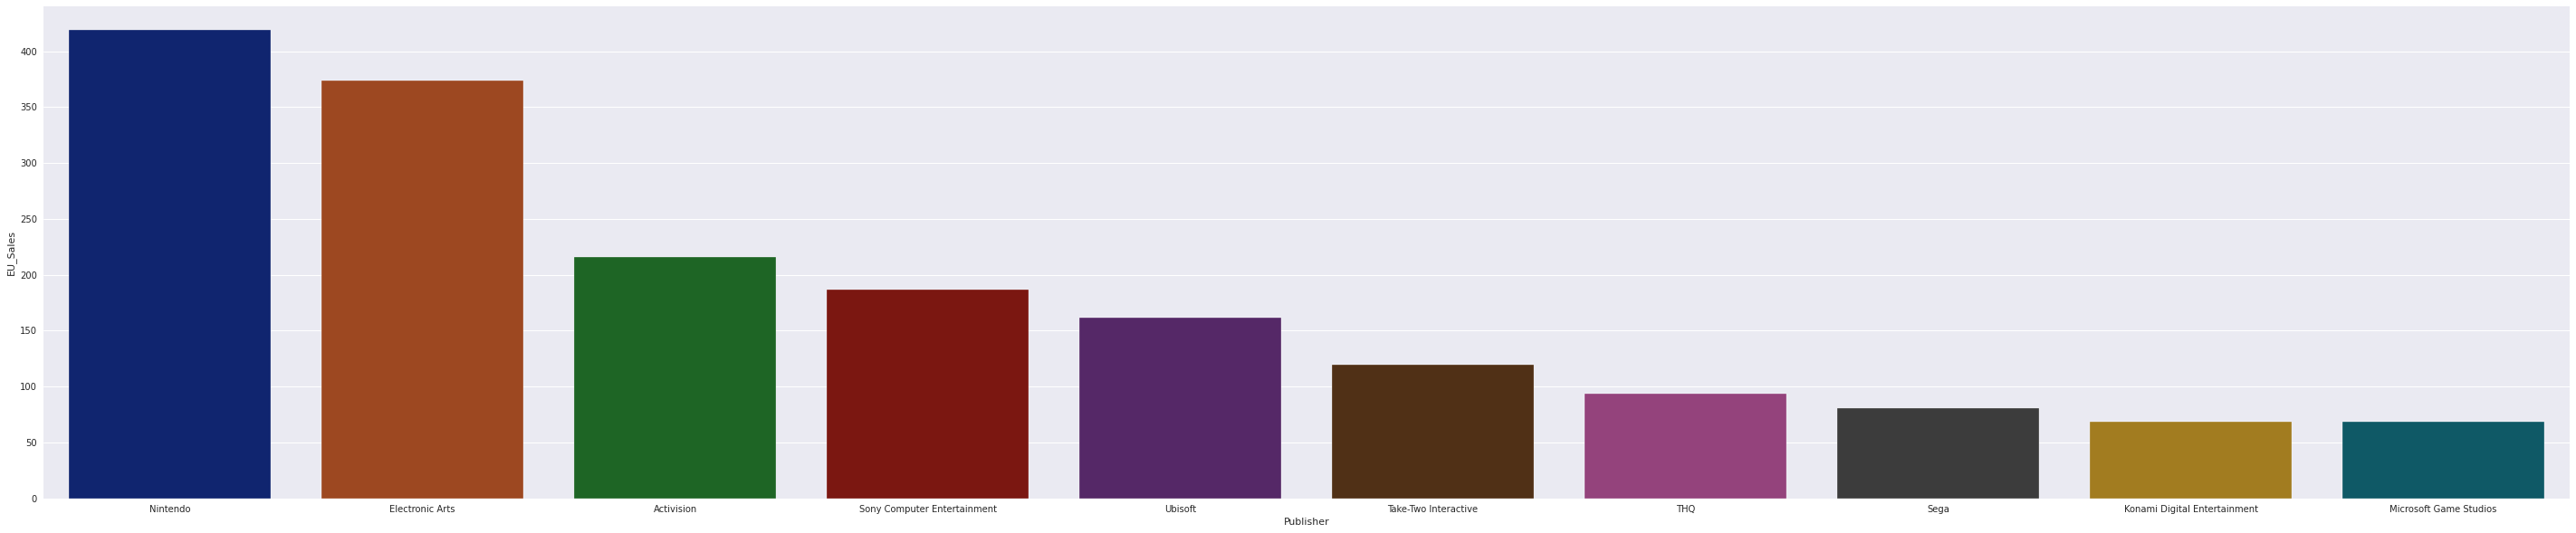

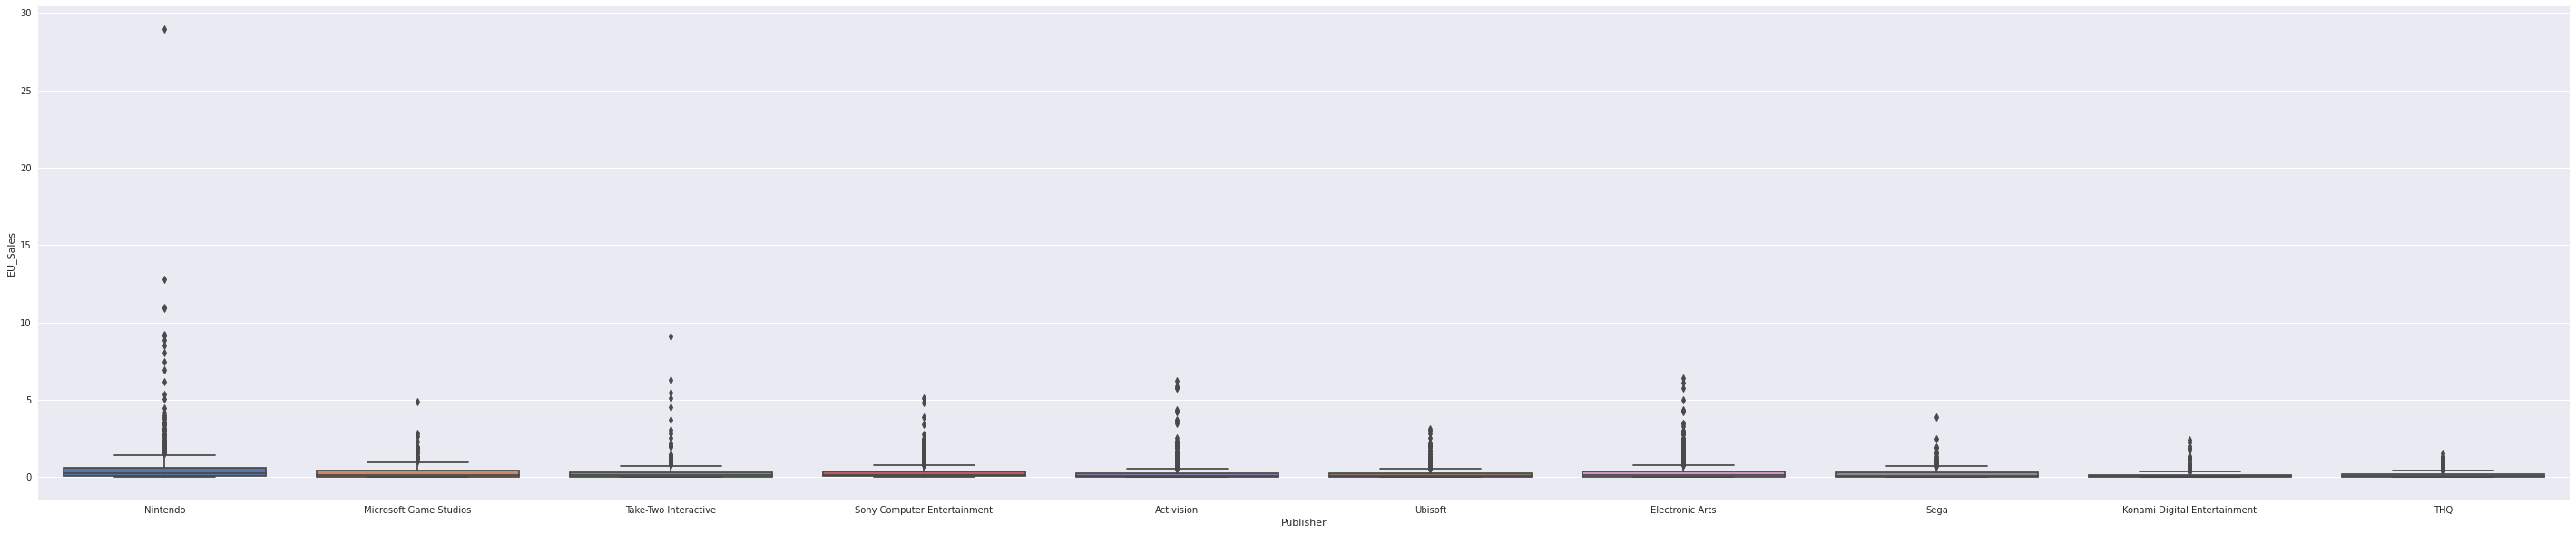

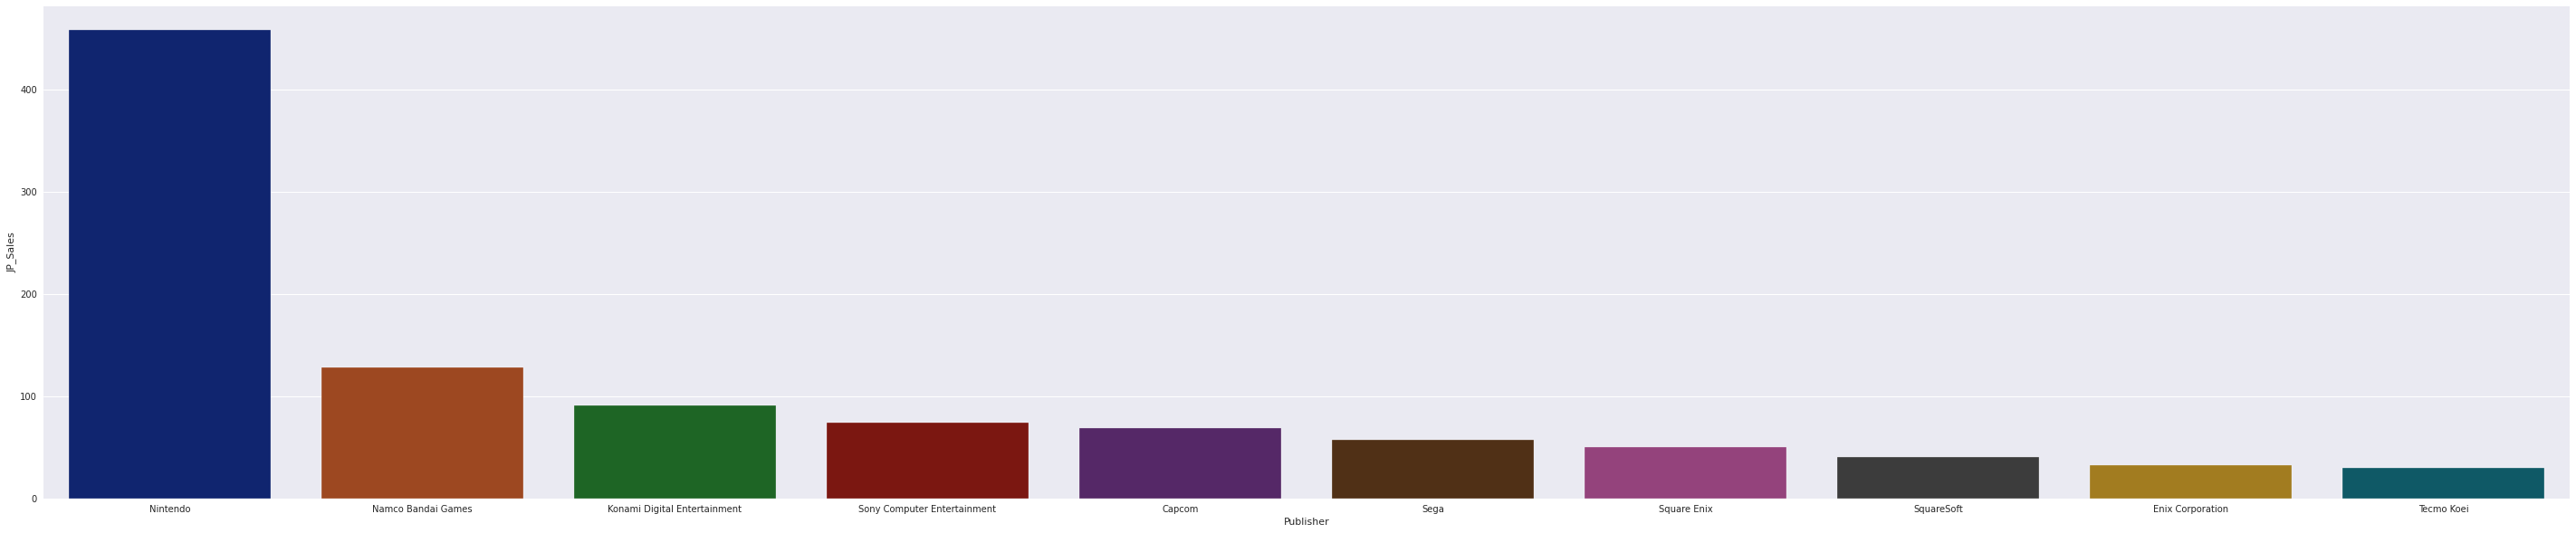

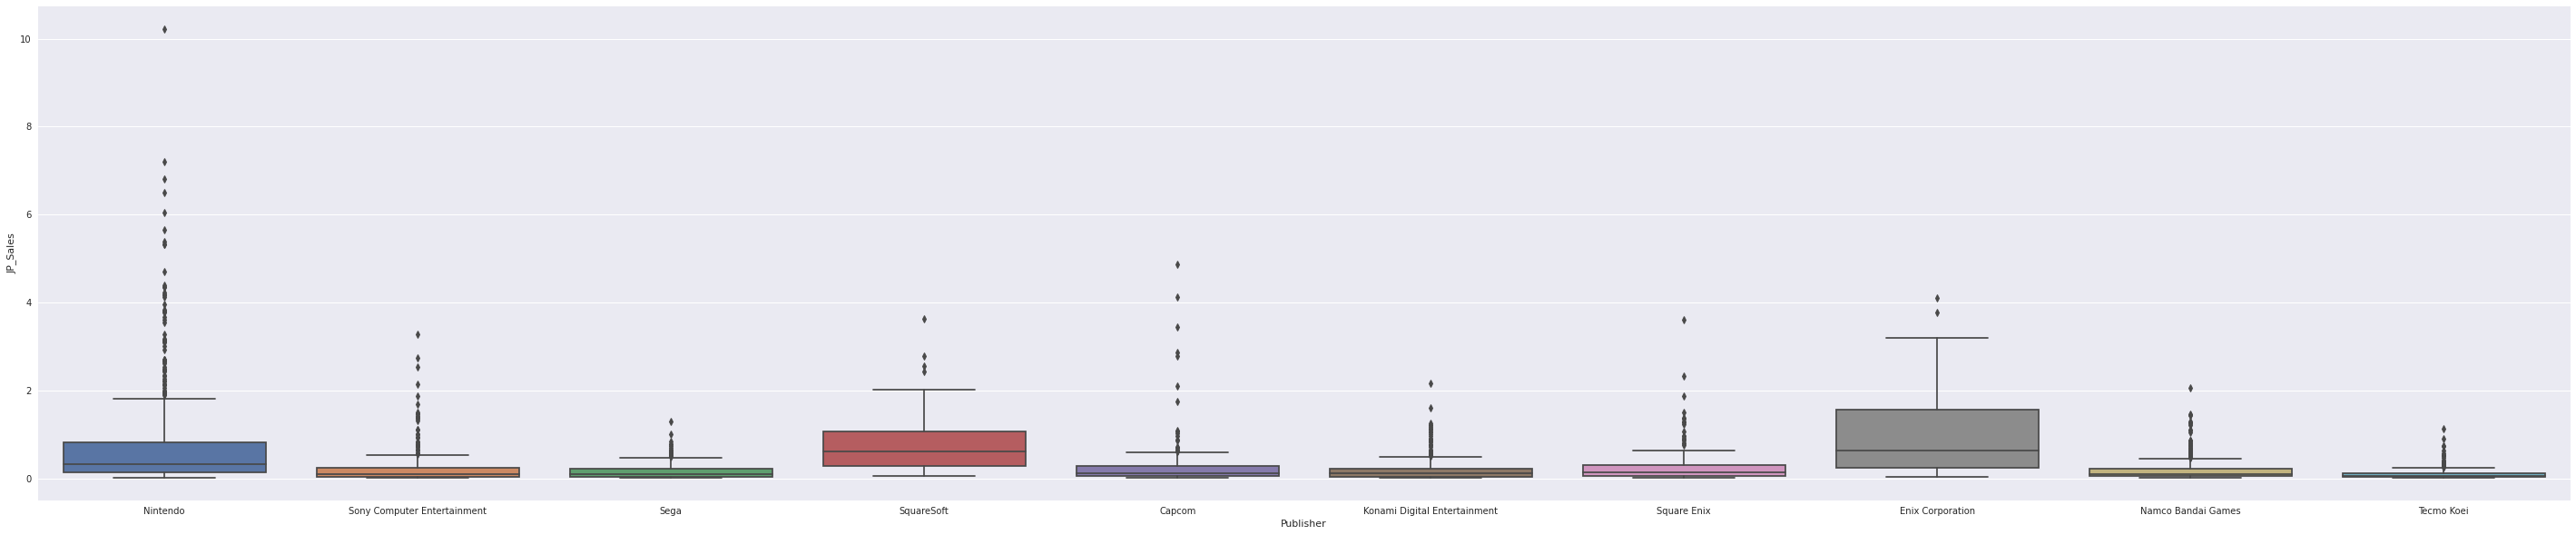

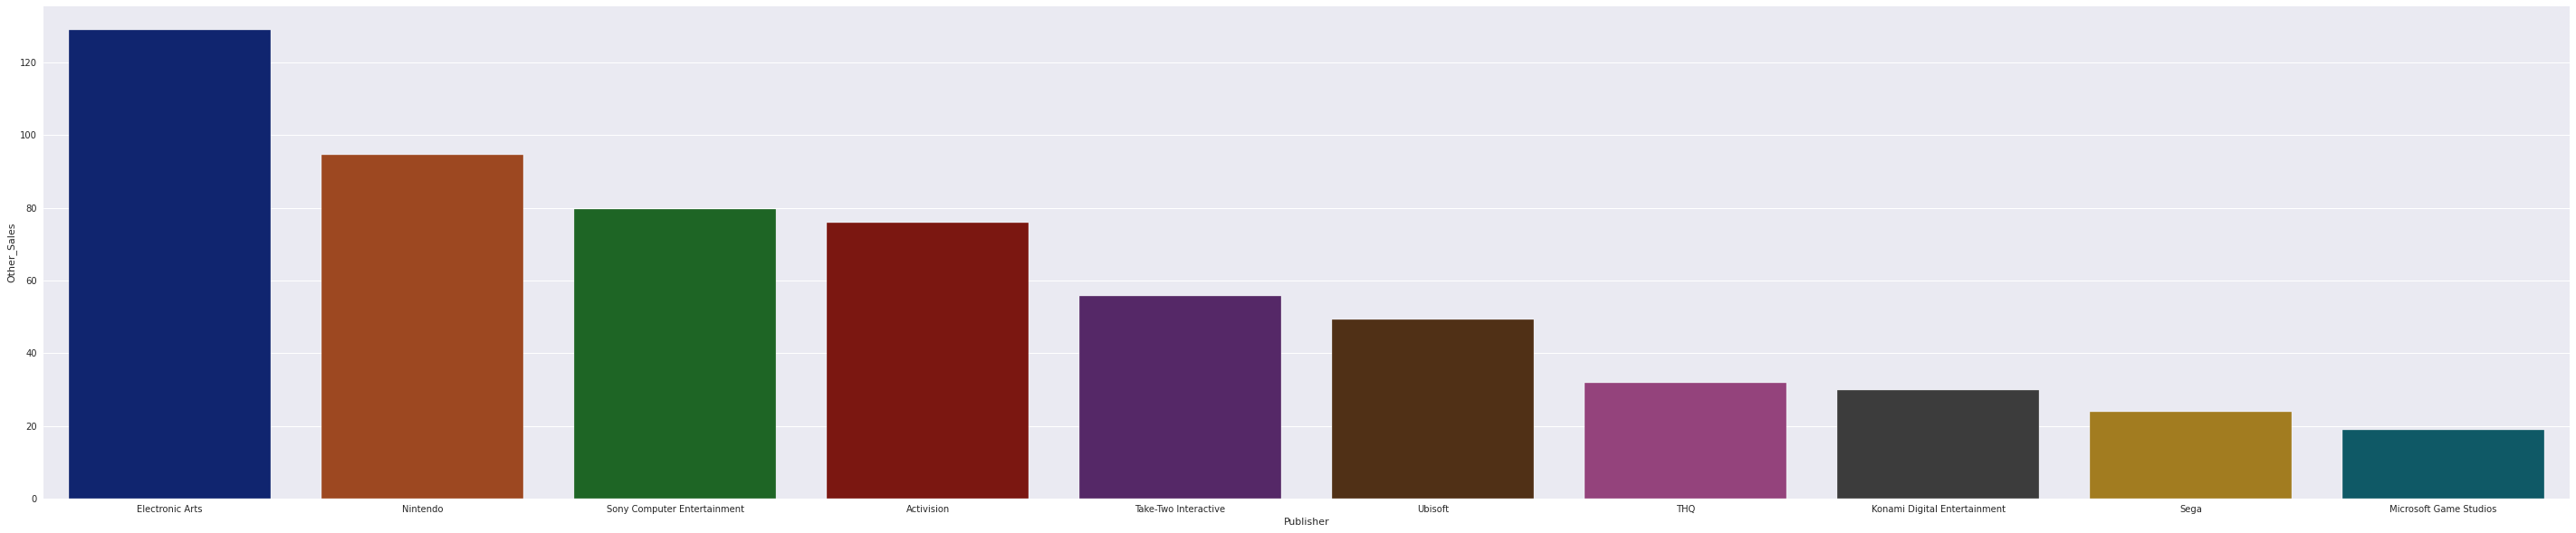

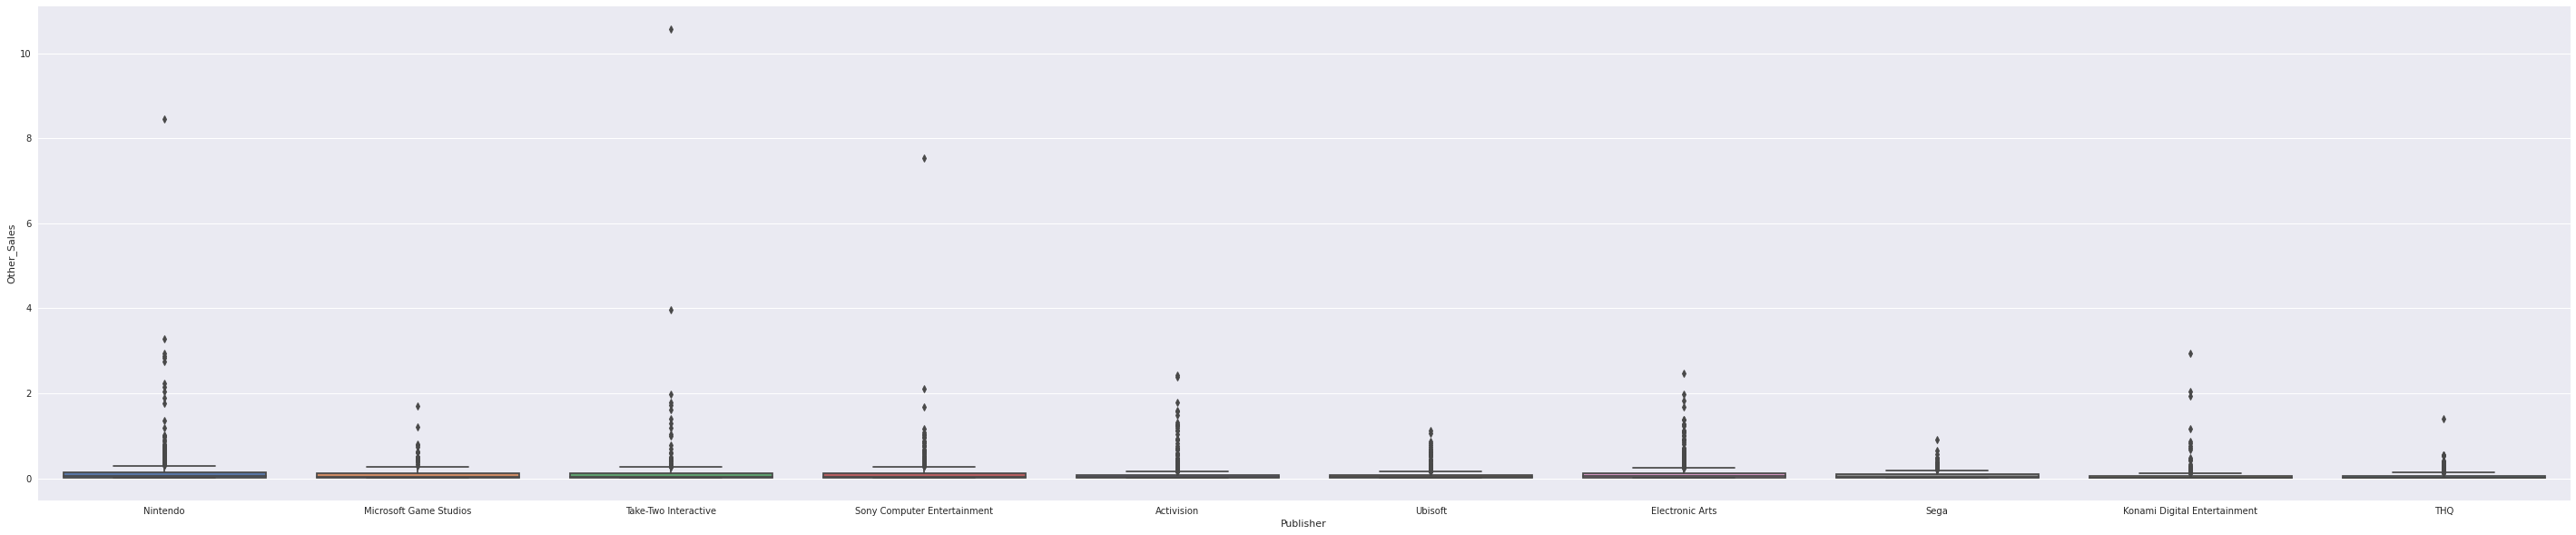

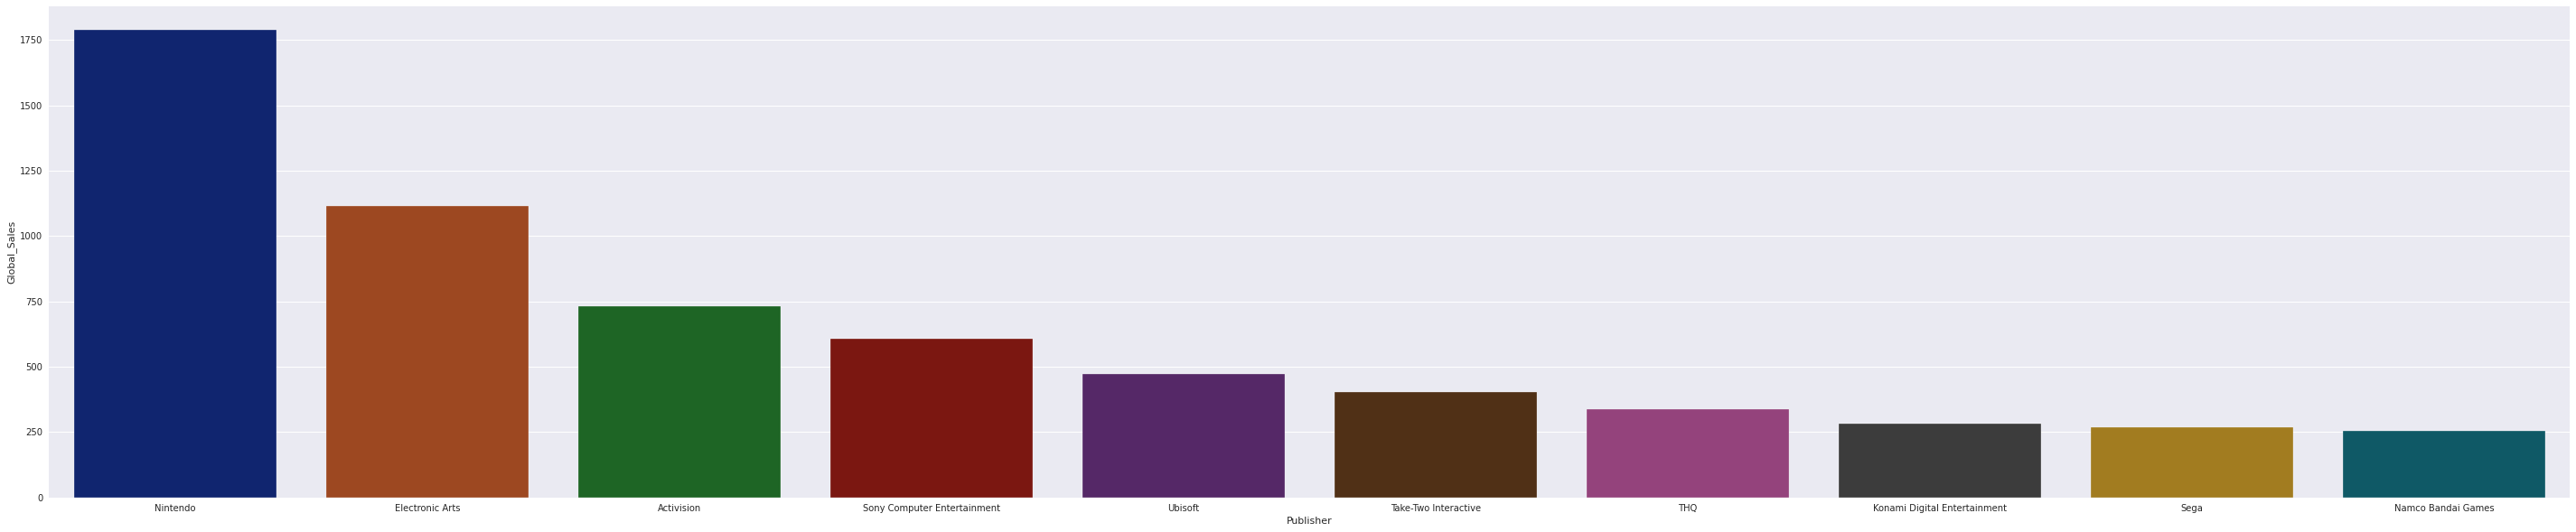

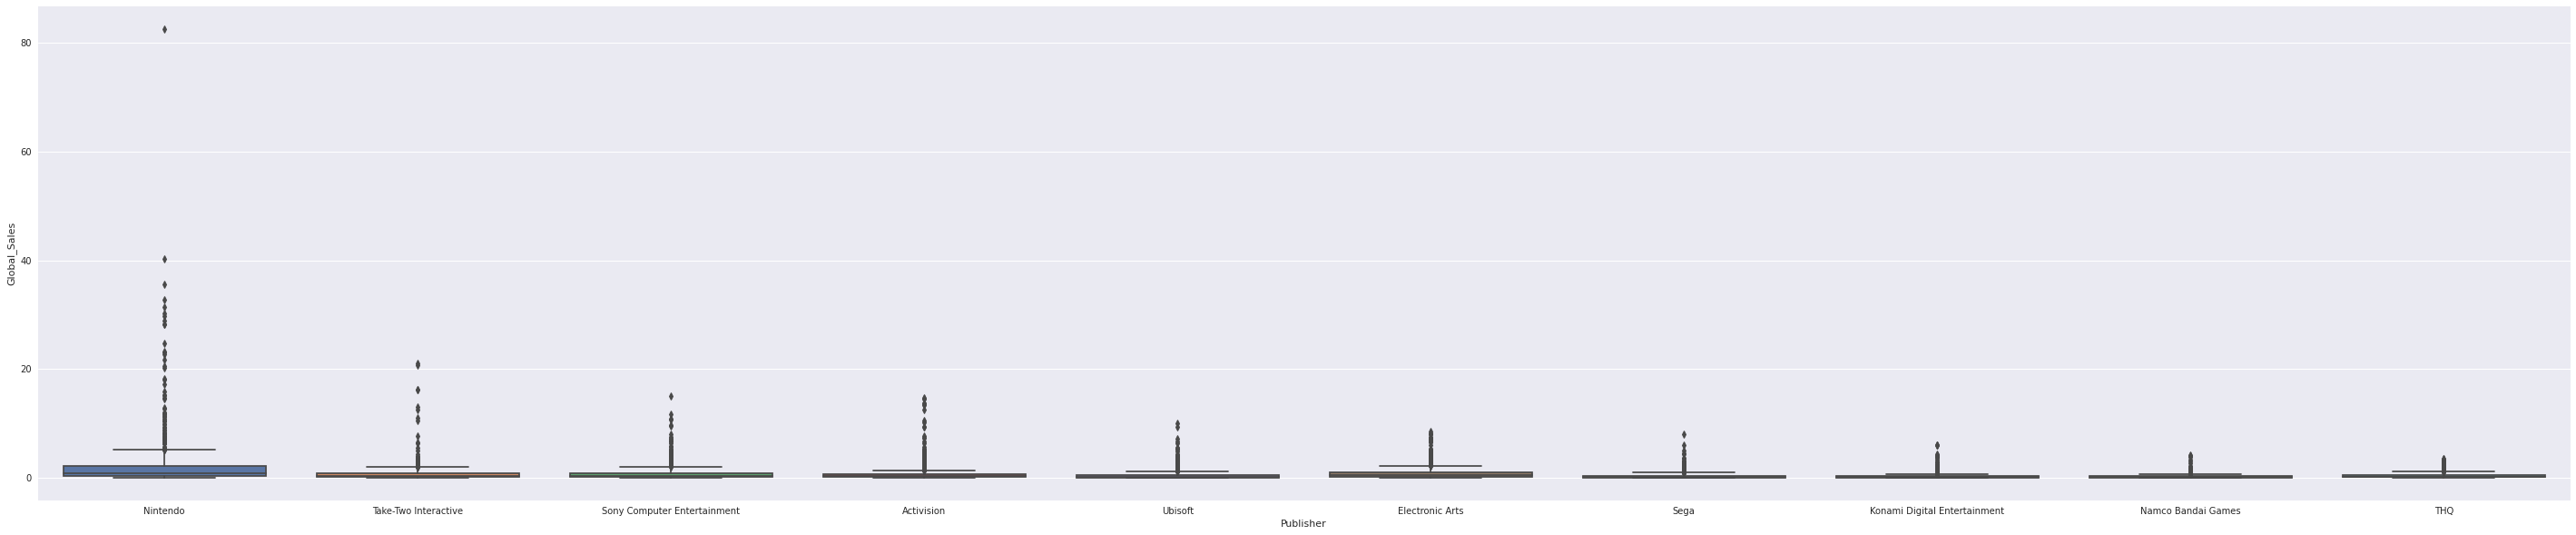

In [13]:
#NA sales
plot_most_popular(cleaned_data,"NA_Sales", "Publisher")
#EU Sales
plot_most_popular(cleaned_data,"EU_Sales", "Publisher")
#JP Sales
plot_most_popular(cleaned_data,"JP_Sales", "Publisher")
#Other Sales
plot_most_popular(cleaned_data,"Other_Sales", "Publisher")
#Global Sales
plot_most_popular(cleaned_data,"Global_Sales", "Publisher")        

Nintendo is the clear winner here despite not having the most number of games. Only losing to EA in the Other region. Furthermore, Xbox was the one of the most popular platform in all regions except for Japan.

# **4. User Score and Critic Score**

Cleaning for User Score and Critic Score

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


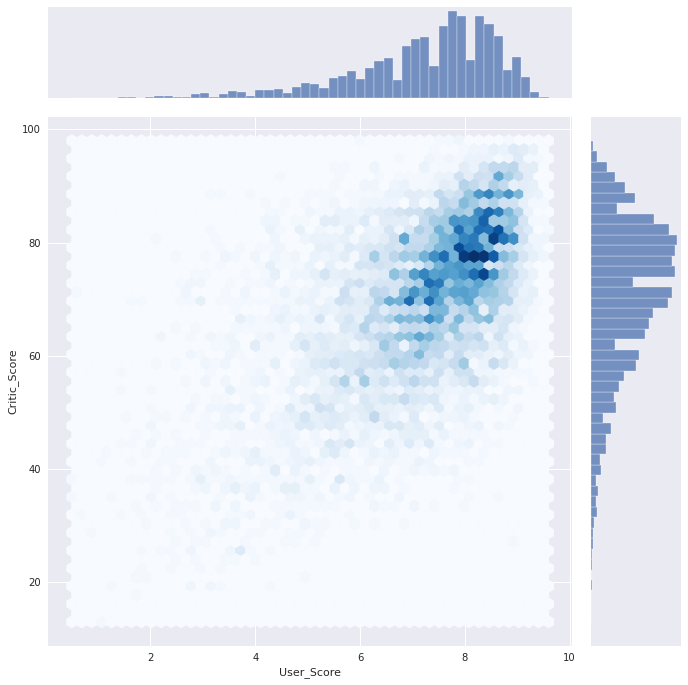

In [14]:
#testing for user_score
cleanedData = data[data["Genre"].notnull()]
cleanedData[["User_Score", "Critic_Score"]] = cleanedData[["User_Score", "Critic_Score"]].replace("tbd", np.nan).astype(float)


#correlation between user_score and critic_score, which is pretty high (high critic score = high user score)
g = sb.jointplot(x="User_Score", y="Critic_Score", data=cleanedData, cmap="Blues", kind="hex", 
                  height=10, marginal_kws={'multiple': 'stack'});

g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)

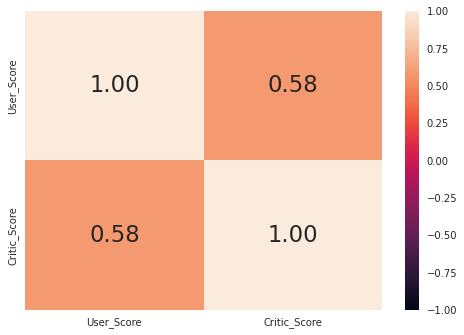

In [15]:
correlation(cleanedData, "User_Score", "Critic_Score")

correlation between user_score and critic_score, which is pretty high (generally high critic score = high user score)

Lets look at the correlation between these two variables and sales in details

For User Score:

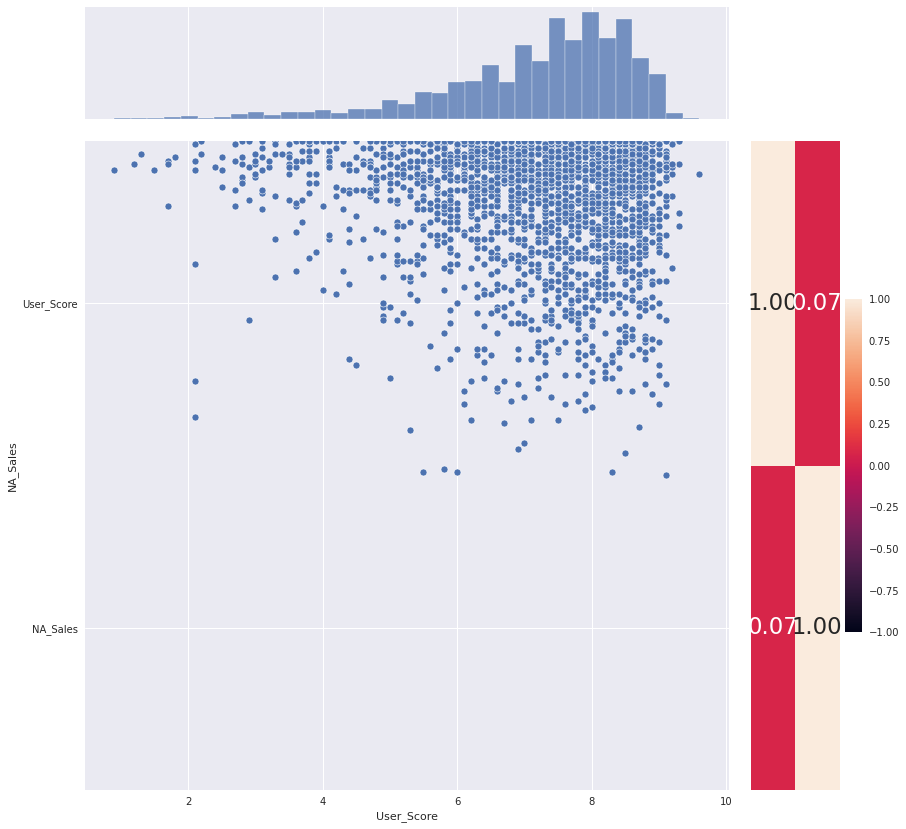

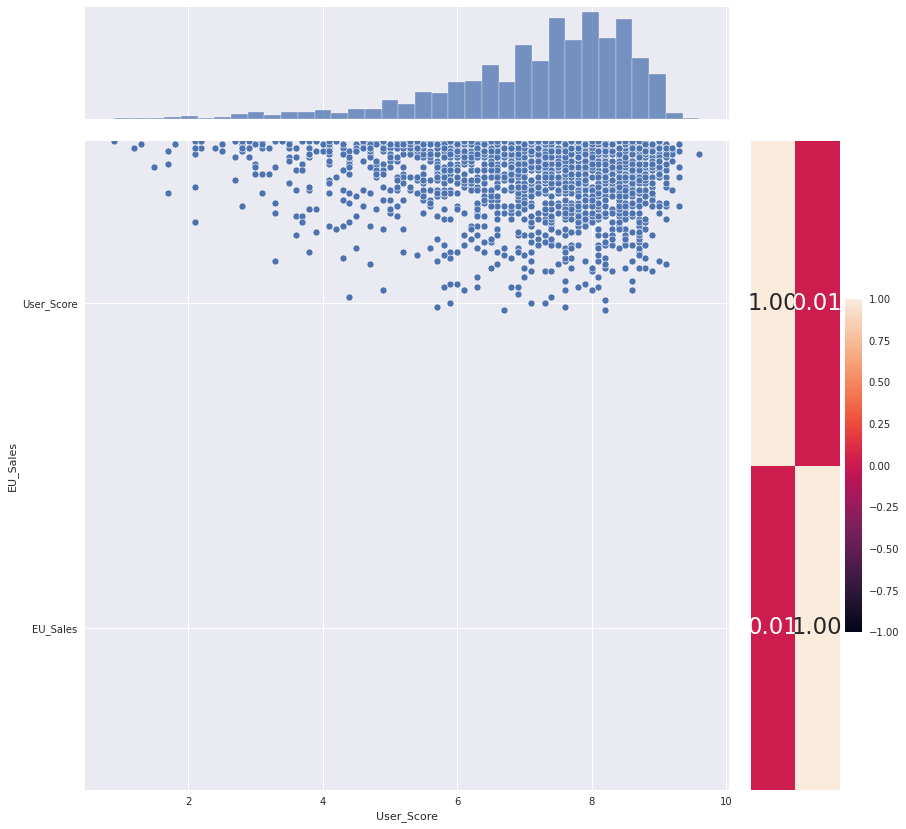

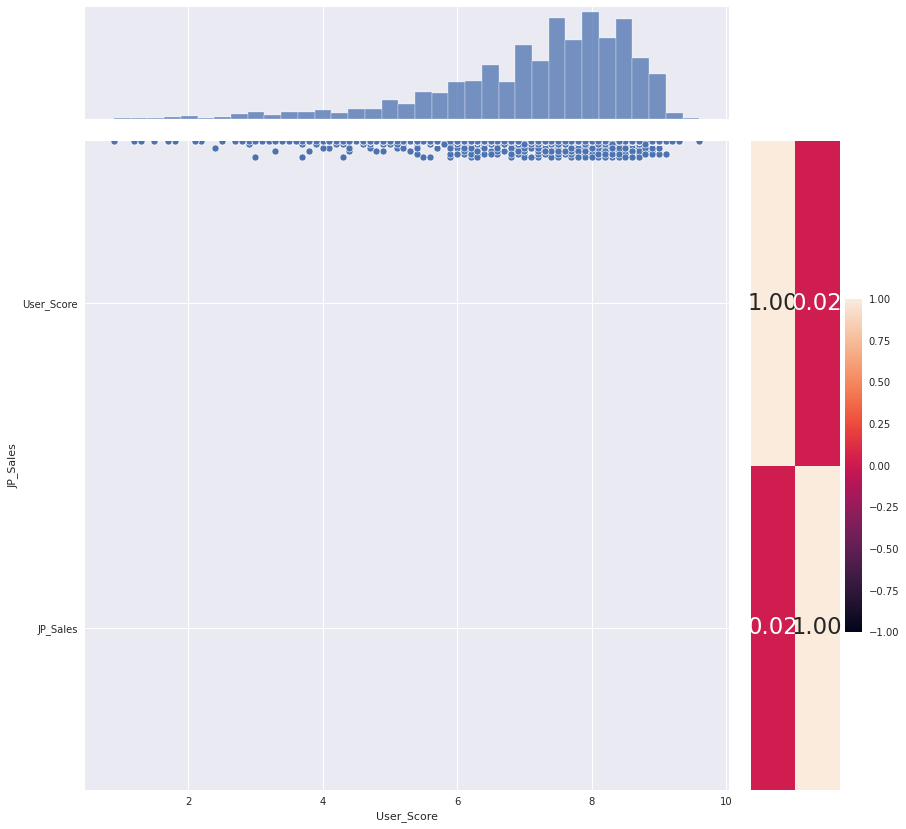

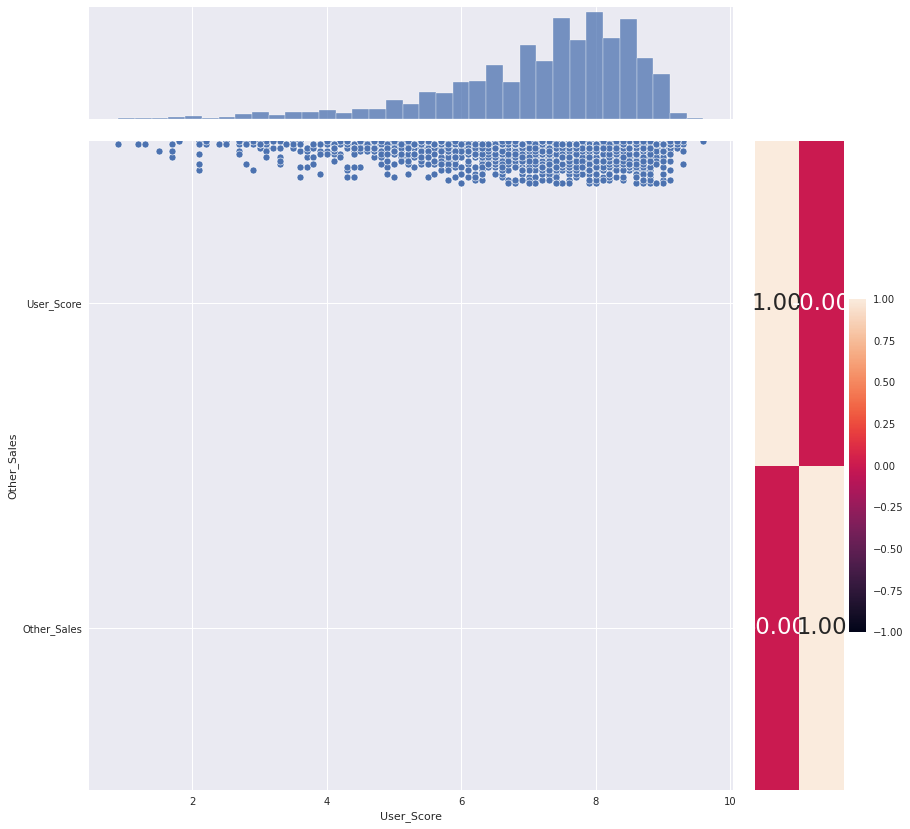

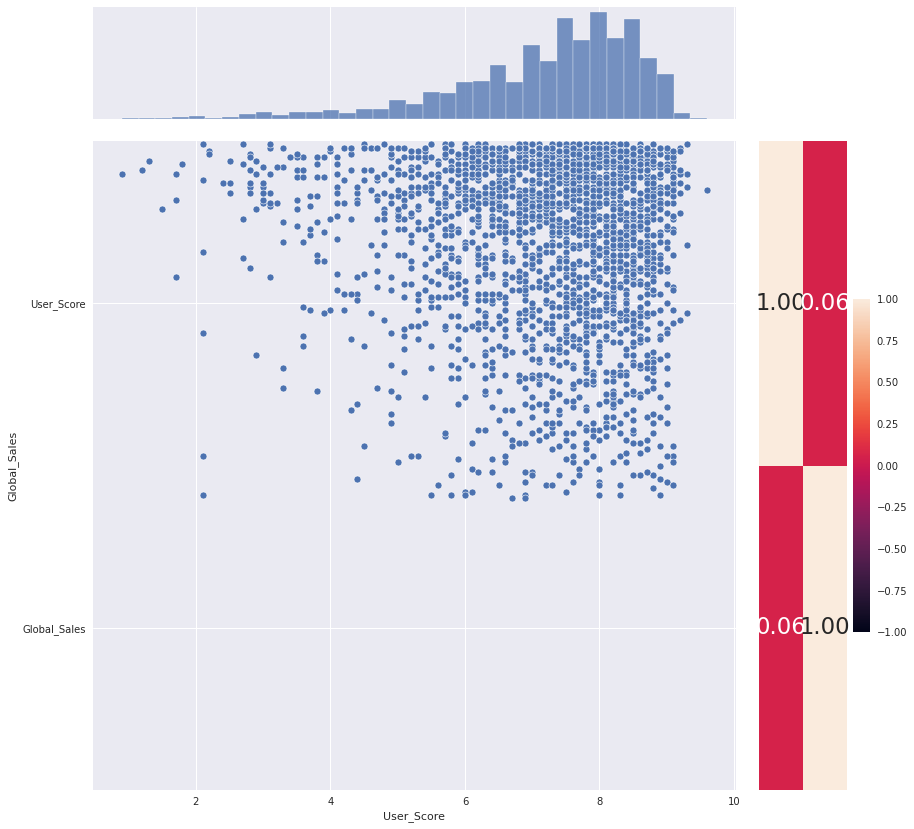

In [16]:
ratings = ['Critic_Score','Critic_Count', 'User_Score', 'User_Count']

cleanedData = null_cleaning(cleanedData, ratings)
cleanedData = value_cleaning(cleanedData, ['Critic_Count', 'User_Count'], 10)
cleanedData = outlier_cleaning(cleanedData, ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"])

userscore_region(cleanedData, "NA_Sales")
correlation(cleanedData, "User_Score", "NA_Sales")

userscore_region(cleanedData, "EU_Sales")
correlation(cleanedData, "User_Score", "EU_Sales")

userscore_region(cleanedData, "JP_Sales")
correlation(cleanedData, "User_Score", "JP_Sales")

userscore_region(cleanedData, "Other_Sales")
correlation(cleanedData, "User_Score", "Other_Sales")

userscore_region(cleanedData, "Global_Sales")
correlation(cleanedData, "User_Score", "Global_Sales")

There is hardly any relation between sales and user score. 

For Critic Score:

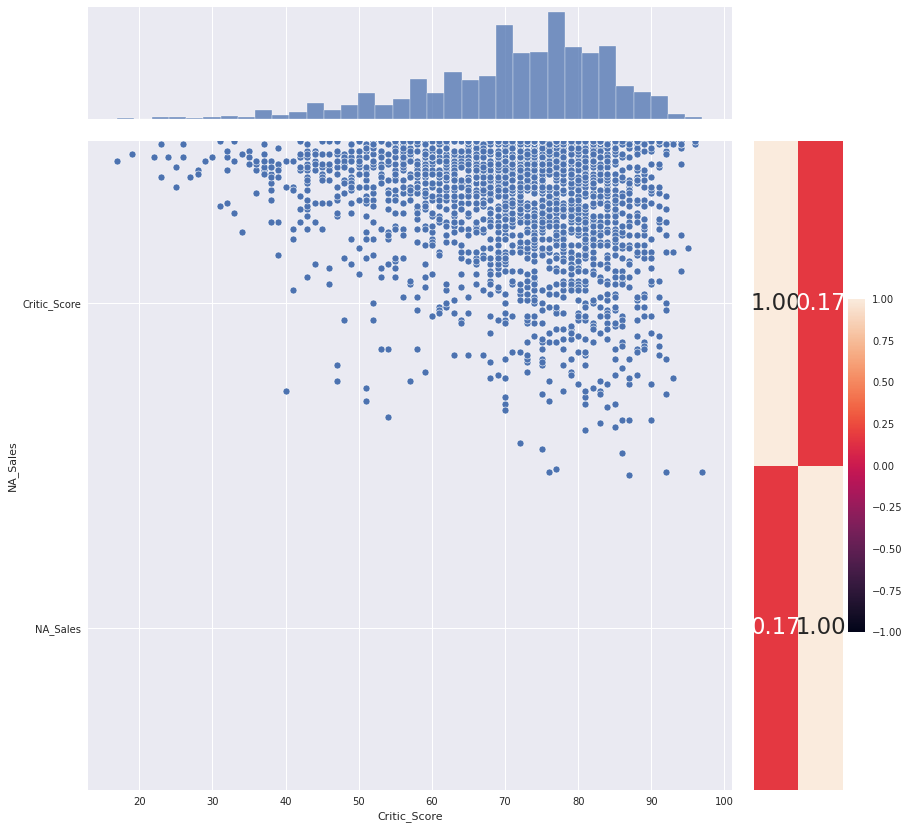

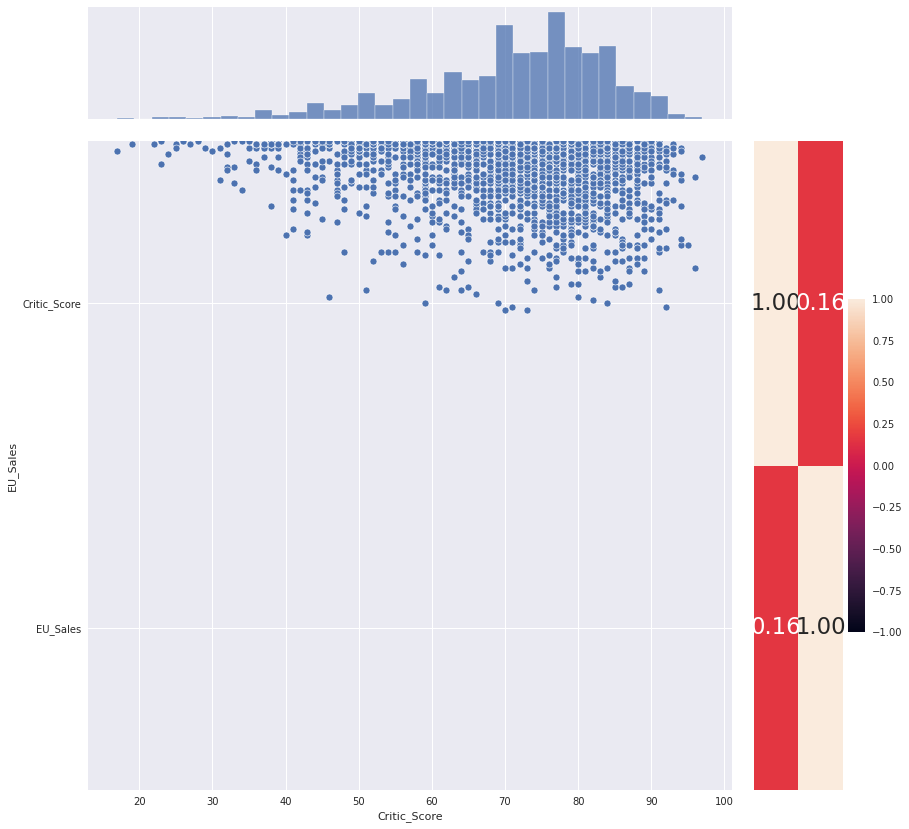

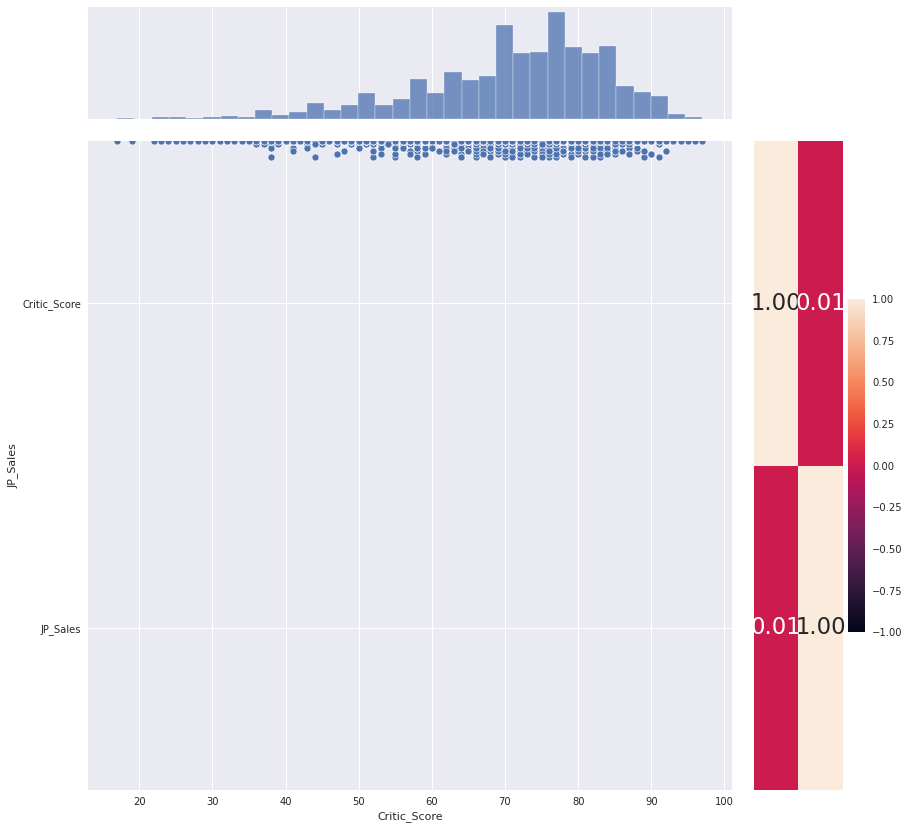

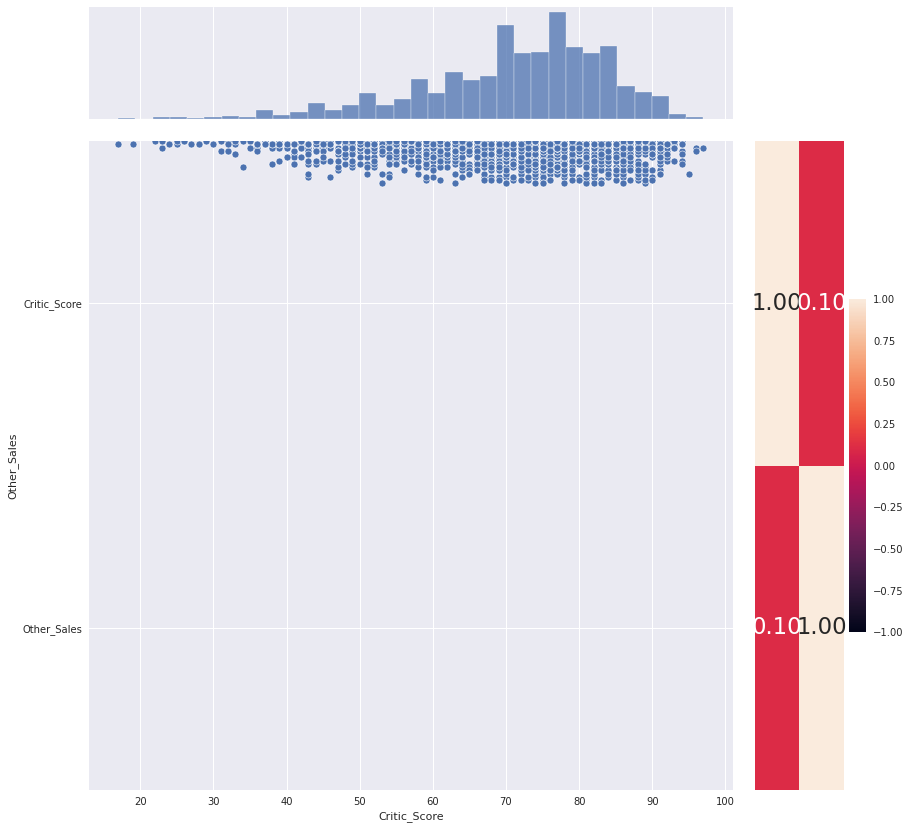

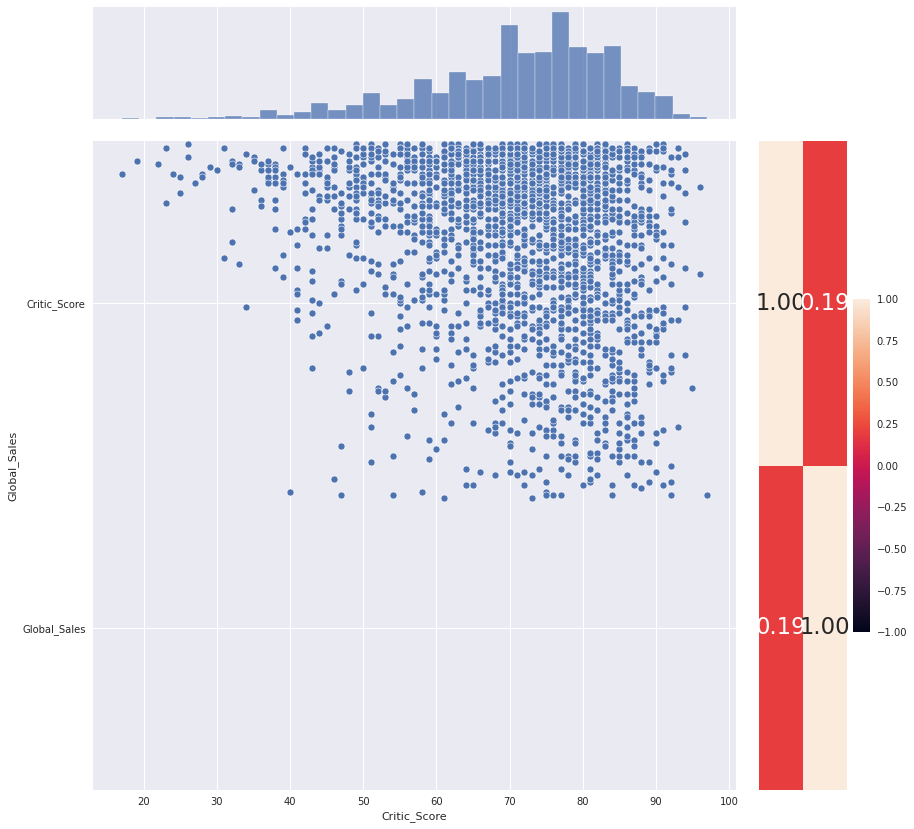

In [17]:
cscore_region(cleanedData, "NA_Sales")
correlation(cleanedData,"Critic_Score", "NA_Sales")

cscore_region(cleanedData, "EU_Sales")
correlation(cleanedData, "Critic_Score", "EU_Sales")

cscore_region(cleanedData, "JP_Sales")
correlation(cleanedData, "Critic_Score", "JP_Sales")

cscore_region(cleanedData, "Other_Sales")
correlation(cleanedData, "Critic_Score", "Other_Sales")

cscore_region(cleanedData, "Global_Sales")
correlation(cleanedData, "Critic_Score", "Global_Sales")

Although Critic Score has a better correlation, it is still super weak..

# **Machine Learning Modelling**

# **1. Dependent Variables**

Since the dependent variables have a high corr with global sales. We decide to do a simple regression to see which region is better at predicting global sales.

Initial data cleaning to prepare for model

In [18]:
predictors = ["JP_Sales", "NA_Sales", "EU_Sales", "Other_Sales", "Global_Sales"]
cleaned_data = null_cleaning(data, predictors)
sales = pd.DataFrame(cleaned_data["Global_Sales"])

Regression model and plotting the results

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Intercept of Regression 	: b =  [0.30562796]
Coefficients of Regression 	: a =  [[2.91876062]]

For predictor JP_Sales:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.40507480820575203
Mean Squared Error (MSE) 	: 1.2064465357551566

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.31994597846622364
Mean Squared Error (MSE) 	: 2.379970596528031

Intercept of Regression 	: b =  [0.28344936]
Coefficients of Regression 	: a =  [[5.20583676]]

For predictor Other_Sales:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.45631692220240727
Mean Squared Error (MSE) 	: 1.102532847498674

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7035894720242046
Mean Squared Error (MSE) 	: 1.0373416210269475

Intercept of Regression 	: b =  [0.07818658]
Coefficients of Regression 	: a =  [[1.7185844]]

For predictor NA_Sales:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.860457025897511
Mean Squared 

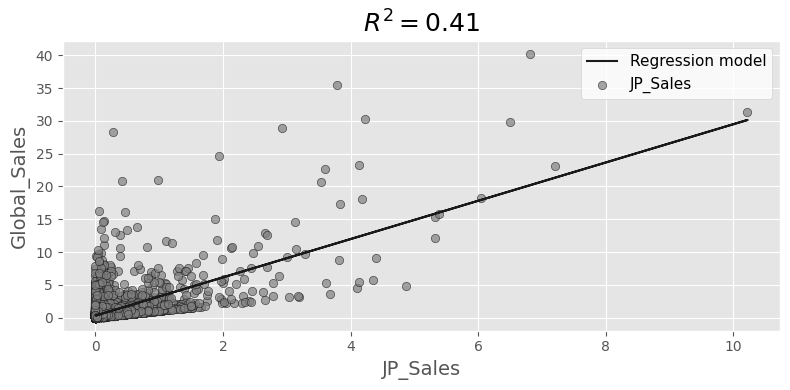

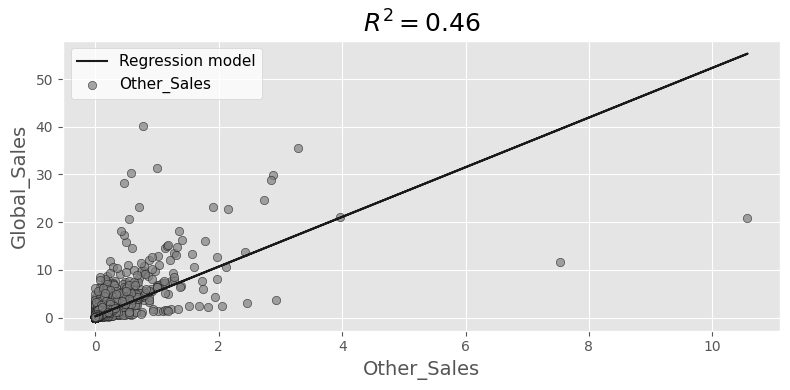

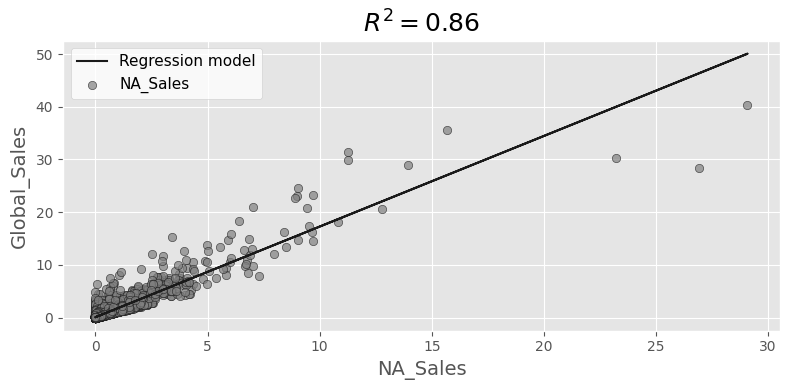

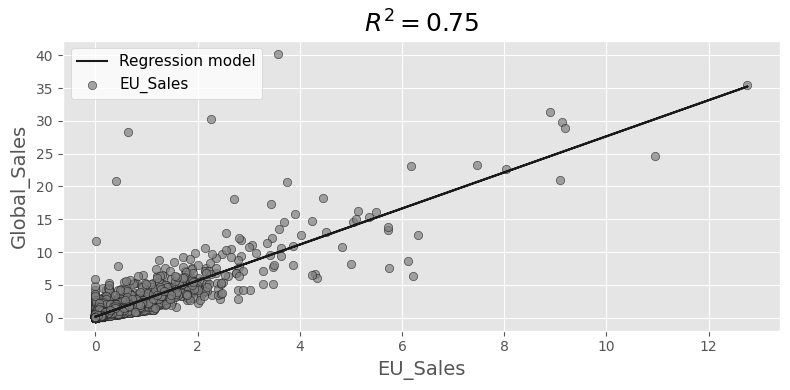

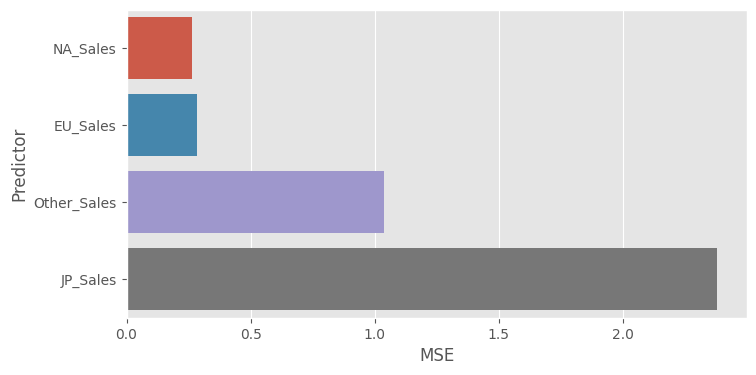

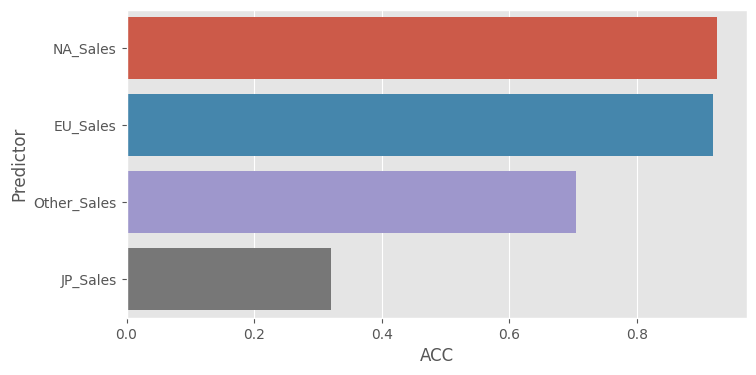

In [20]:
result_listx = []
result_listx.append(reg(cleaned_data,sales, "JP_Sales"))
result_listx.append(reg(cleaned_data,sales, "Other_Sales"))
result_listx.append(reg(cleaned_data,sales, "NA_Sales"))
result_listx.append(reg(cleaned_data,sales, "EU_Sales"))
acc_df = pd.DataFrame(result_listx, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)


Let's see if the model changes with some further cleaning.

Intercept of Regression 	: b =  [0.20280605]
Coefficients of Regression 	: a =  [[0.64048184]]

For predictor JP_Sales:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.07227936753612663
Mean Squared Error (MSE) 	: 0.05366659182329607

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.07614914595252986
Mean Squared Error (MSE) 	: 0.05482237261951716

Intercept of Regression 	: b =  [0.14132029]
Coefficients of Regression 	: a =  [[4.62143776]]

For predictor Other_Sales:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4511540901225053
Mean Squared Error (MSE) 	: 0.031749525006309544

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.44515896456568627
Mean Squared Error (MSE) 	: 0.03292490541727174

Intercept of Regression 	: b =  [0.08204602]
Coefficients of Regression 	: a =  [[1.27840682]]

For predictor NA_Sales:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6500695222600111
Mean

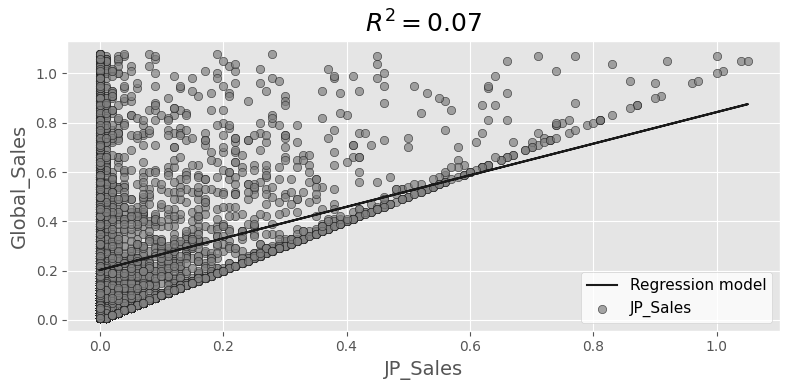

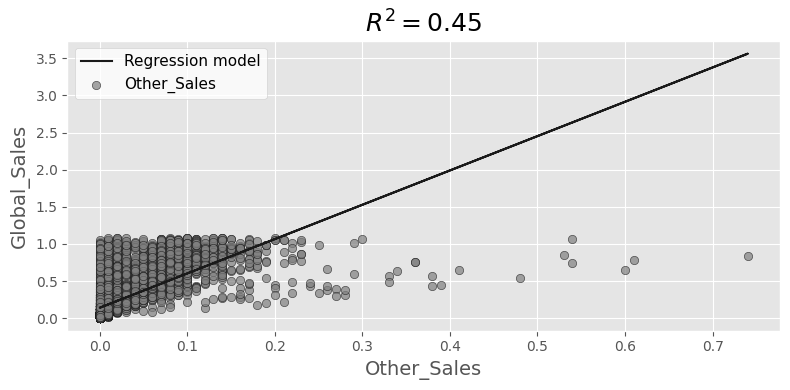

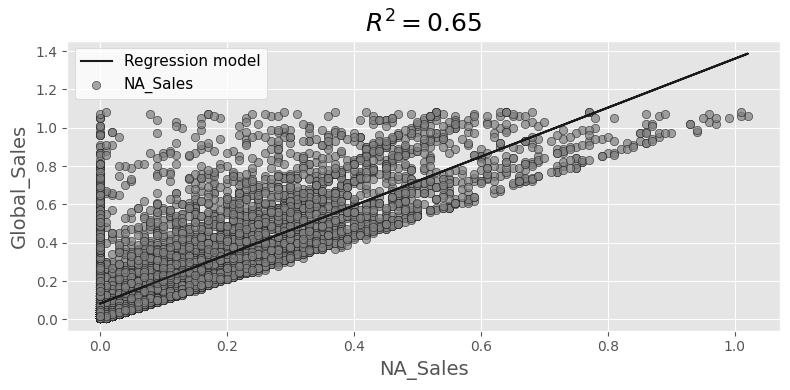

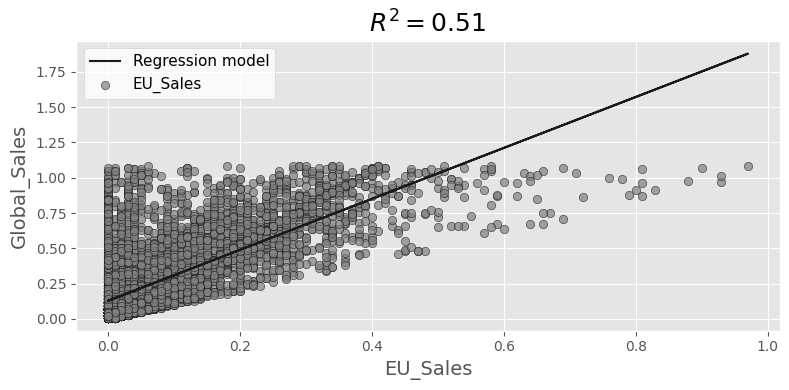

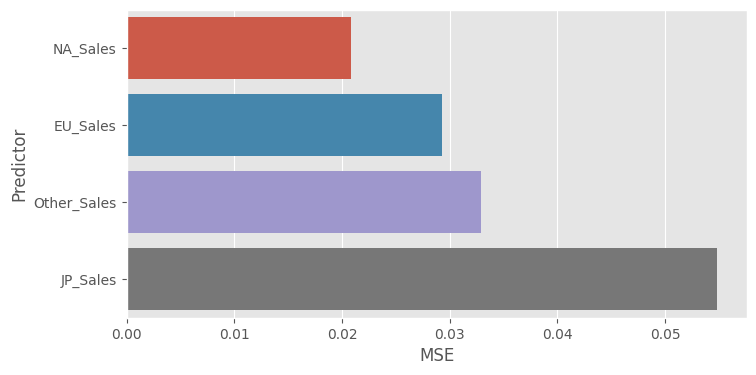

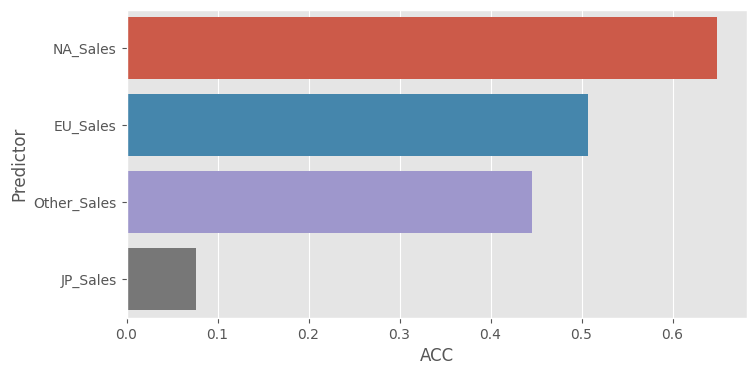

In [21]:
cleaned_data = null_cleaning(data, predictors)
cleaned_data = outlier_cleaning(cleaned_data, ["Global_Sales"])
sales = pd.DataFrame(cleaned_data["Global_Sales"])
result_listc = []
result_listc.append(reg(cleaned_data,sales, "JP_Sales"))
result_listc.append(reg(cleaned_data,sales, "Other_Sales"))
result_listc.append(reg(cleaned_data,sales, "NA_Sales"))
result_listc.append(reg(cleaned_data,sales, "EU_Sales"))
acc_df = pd.DataFrame(result_listc, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)

In either cases we can see that NA sales is the best at predicting global sales with EU sales close behind. and Interestingly, there is a significant decrease in the accuracy for JP sales after removing outliers, suggesting that Japan as region might have a different taste from other regions.

Lets try with another model(Gradient Boosting regressor) to see if the results improve

In [22]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.67306990611092
Mean Squared Error (MSE) 	: 0.019400407922121093

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5396220950016346
Mean Squared Error (MSE) 	: 0.027319354572265413

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.11964056518270938
Mean Squared Error (MSE) 	: 0.05224154176316984

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5941565548969541
Mean Squared Error (MSE) 	: 0.02408321697723354



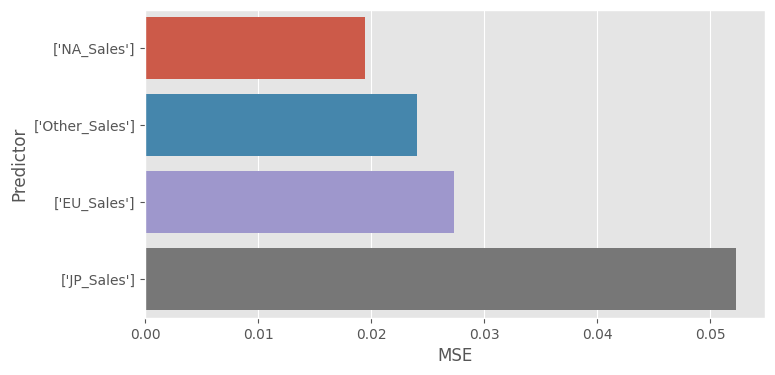

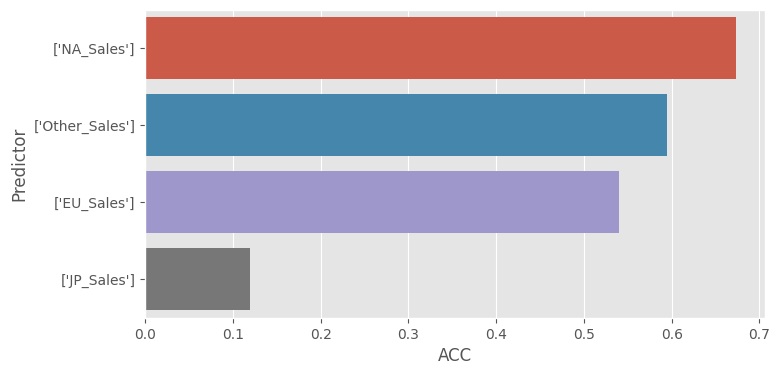

In [23]:
result_list = []
result_list.append(grad(cleaned_data, sales, ["NA_Sales"]))
result_list.append(grad(cleaned_data, sales, ["EU_Sales"]))
result_list.append(grad(cleaned_data, sales, ["JP_Sales"]))
result_list.append(grad(cleaned_data, sales, ["Other_Sales"]))

acc_df = pd.DataFrame(result_list, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')

fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)


# **2.Rating Scores**

Let see how good rating scores are at predicting global sales.

Initial Cleaning:

In [24]:
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)
cleaned_data = data
cleaning = ['Critic_Score','Critic_Count', 'User_Score', 'User_Count', 'Global_Sales', 'Rating']
cleaned_data = null_cleaning(data, cleaning)
print(cleaned_data.shape)


(6947, 16)


Basic Modelling

       Year_of_Release     NA_Sales     EU_Sales     JP_Sales  Other_Sales  \
count      6826.000000  6947.000000  6947.000000  6947.000000  6947.000000   
mean       2007.437299     0.392840     0.234648     0.063236     0.082189   
std           4.211160     0.961157     0.682293     0.285257     0.267832   
min        1985.000000     0.000000     0.000000     0.000000     0.000000   
25%        2004.000000     0.060000     0.020000     0.000000     0.010000   
50%        2007.000000     0.150000     0.060000     0.000000     0.020000   
75%        2011.000000     0.390000     0.210000     0.010000     0.070000   
max        2016.000000    41.360000    28.960000     6.500000    10.570000   

       Global_Sales  Critic_Score  Critic_Count  User_Score    User_Count  
count   6947.000000   6947.000000   6947.000000  6947.00000   6947.000000  
mean       0.773098     70.263567     28.873615     7.18336    173.821362  
std        1.948883     13.888922     19.195731     1.44200    584.51

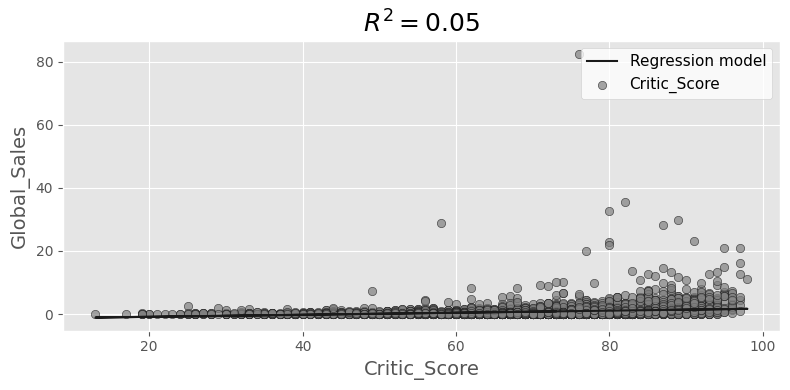

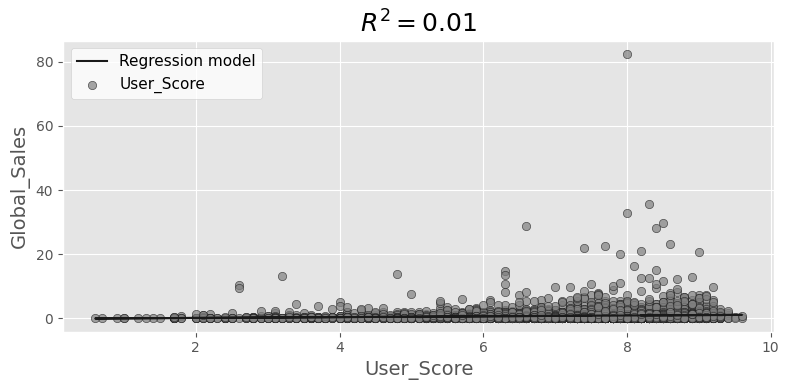

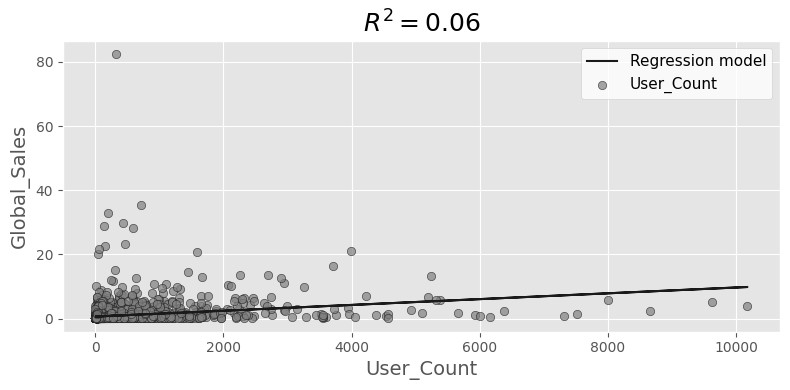

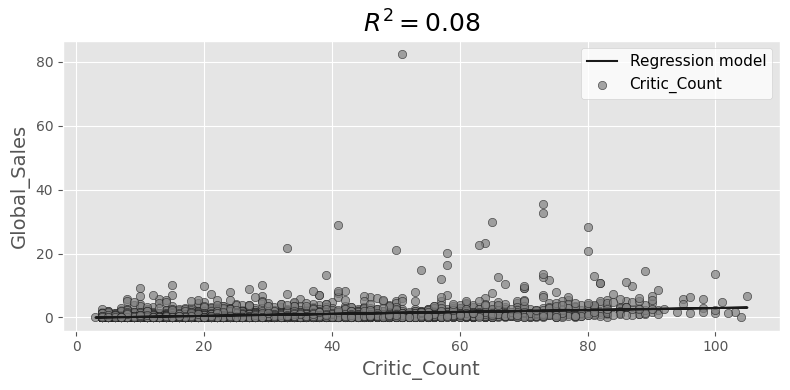

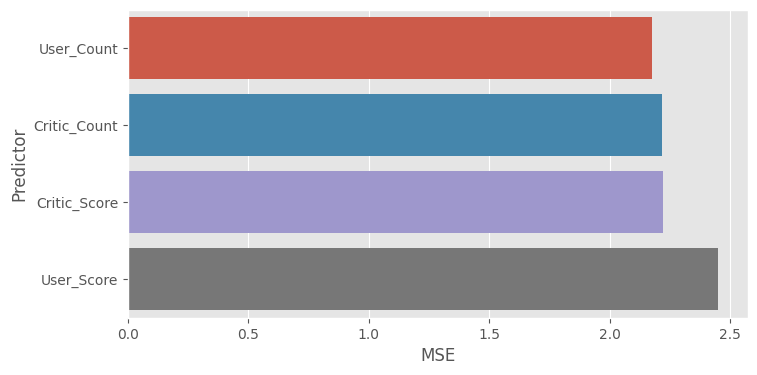

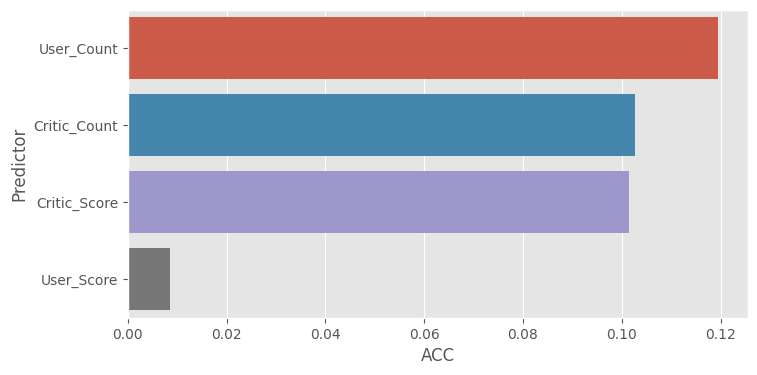

In [25]:
print(cleaned_data.describe())
sales = pd.DataFrame(cleaned_data["Global_Sales"])
predictors = cleaned_data[["Critic_Score", "User_Count", "Critic_Count", "User_Score"]]
correlations = cleaned_data.corr()["Global_Sales"].dropna().sort_values()

result_list = []
result_list.append(reg(predictors,sales, "Critic_Score"))
result_list.append(reg(predictors,sales, "User_Score"))
result_list.append(reg(predictors,sales, "User_Count"))
result_list.append(reg(predictors,sales, "Critic_Count"))
acc_df = pd.DataFrame(result_list, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)

Let's clean the data a bit to see if anything changes

Intercept of Regression 	: b =  [-0.06442262]
Coefficients of Regression 	: a =  [[0.00574246]]

For predictor Critic_Score:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.06686800655803216
Mean Squared Error (MSE) 	: 0.08387232186258382

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.06170941440313116
Mean Squared Error (MSE) 	: 0.09385336176193515

Intercept of Regression 	: b =  [0.14276913]
Coefficients of Regression 	: a =  [[0.02523945]]

For predictor User_Score:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.015274433848606273
Mean Squared Error (MSE) 	: 0.08850968588689932

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.018872462979589
Mean Squared Error (MSE) 	: 0.09813816644872063

Intercept of Regression 	: b =  [0.26333295]
Coefficients of Regression 	: a =  [[0.00174858]]

For predictor User_Count:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0489233303892299

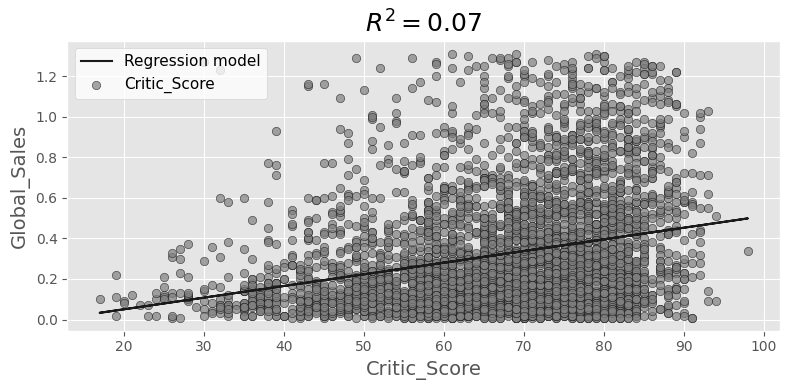

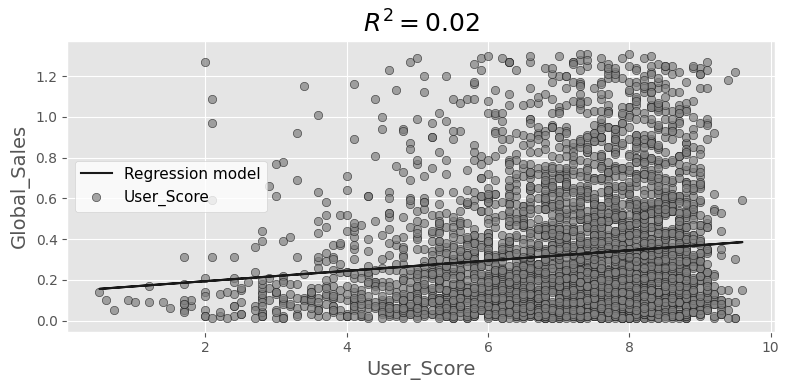

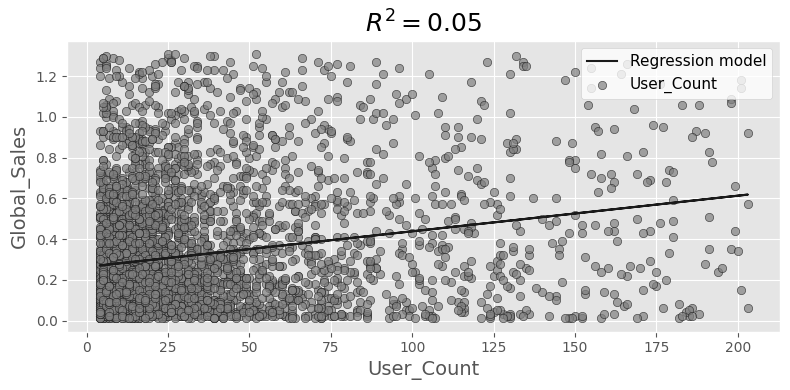

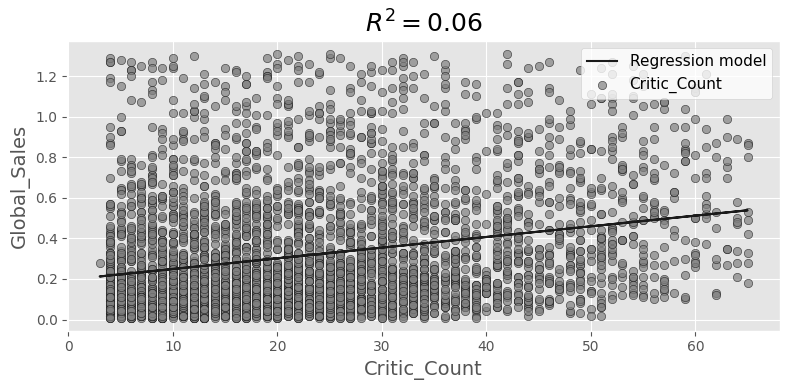

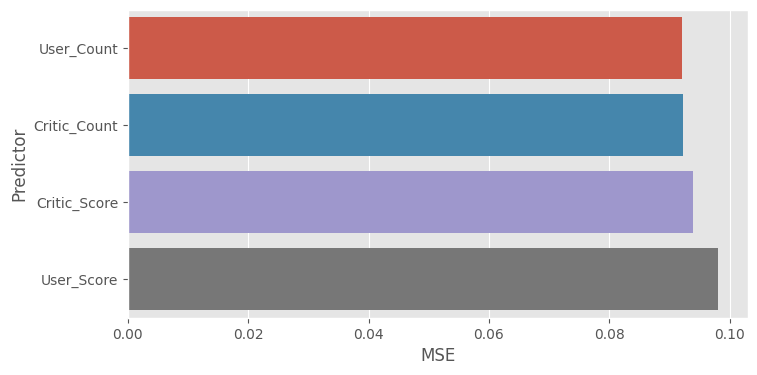

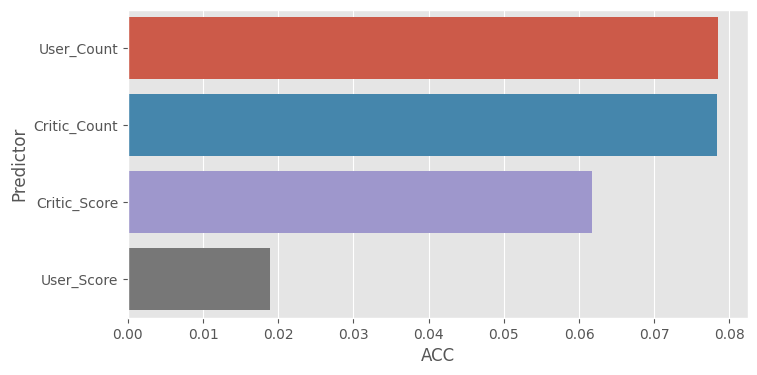

In [26]:
cleaned_data = outlier_cleaning(cleaned_data, ["User_Count", "Critic_Count",  "Global_Sales"])
sales = pd.DataFrame(cleaned_data["Global_Sales"])
predictors = cleaned_data[["Critic_Score", "User_Count", "Critic_Count", "User_Score"]]
correlations = cleaned_data.corr()["Global_Sales"].dropna().sort_values()

result_list = []
result_list.append(reg(predictors,sales, "Critic_Score"))
result_list.append(reg(predictors,sales, "User_Score"))
result_list.append(reg(predictors,sales, "User_Count"))
result_list.append(reg(predictors,sales, "Critic_Count"))
acc_df = pd.DataFrame(result_list, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)


As expected rating scores is not good at predicting global sales

# **3. Genre**

Let's see if this catergorical variable can give any insights

Initial cleaning

In [27]:
predictors = ["JP_Sales", "NA_Sales", "EU_Sales", "Other_Sales", "Global_Sales","Genre"]
cleaned_data = null_cleaning(data, predictors)
print(cleaned_data["Genre"].value_counts())
sales = pd.DataFrame(cleaned_data["Global_Sales"])

Action          3370
Sports          2348
Misc            1750
Role-Playing    1500
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       874
Fighting         849
Strategy         683
Puzzle           580
Name: Genre, dtype: int64


Ordinal Encoder to convert our Genre into numerical values

In [28]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
cleaned_data["Genre_Converted"] = ord_enc.fit_transform(cleaned_data[["Genre"]])

Lets try a normal regression model on this

Intercept of Regression 	: b =  [0.48719179]
Coefficients of Regression 	: a =  [[0.00840679]]

For predictor Genre_Converted:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.0004921908843896761
Mean Squared Error (MSE) 	: 2.026610802488793

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.0005685815464183674
Mean Squared Error (MSE) 	: 3.498686801086995



['Genre_Converted', 0.0005685815464183674, 3.498686801086995]

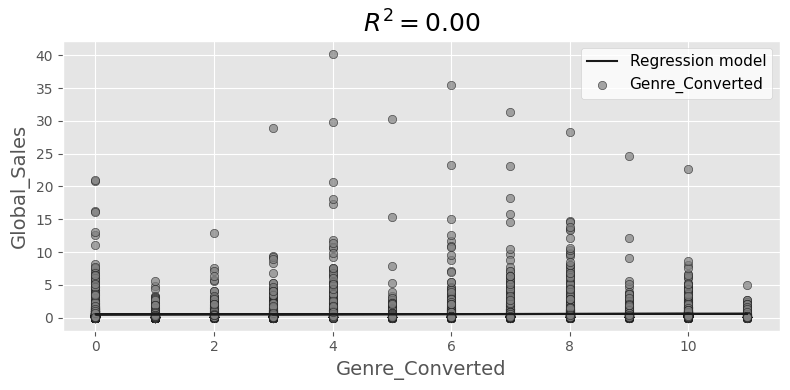

In [29]:
reg(cleaned_data,sales,"Genre_Converted")

Not very ideal. Lets try it with the KNeightborsRegressor model

In [30]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
knn = KNeighborsRegressor(n_neighbors=10)
fit_and_eval(cleaned_data, 'Genre_Converted', 'Global_Sales', knn)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: -0.1535823258159974
Mean Squared Error (MSE) 	: 2.3390136442530114


Even worse results.

# **4. Region Sales and Genre**

Intercept of Regression 	: b =  [0.0683999]
Coefficients of Regression 	: a =  [[1.7188414  0.00231842]]

For predictor ['NA_Sales', 'Genre_Converted']:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8604812950304785
Mean Squared Error (MSE) 	: 0.28288935019993844

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9251892840222958
Mean Squared Error (MSE) 	: 0.2618881693513801

Intercept of Regression 	: b =  [0.1208603]
Coefficients of Regression 	: a =  [[2.75533668 0.00306893]]

For predictor ['EU_Sales', 'Genre_Converted']:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7517426801098726
Mean Squared Error (MSE) 	: 0.5033687197816115

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9173334808000595
Mean Squared Error (MSE) 	: 0.28938880074848217

Intercept of Regression 	: b =  [0.29498539]
Coefficients of Regression 	: a =  [[2.90140413e+00 1.62673787e-03]]

For predictor ['JP_Sales', 'Genre_Conve

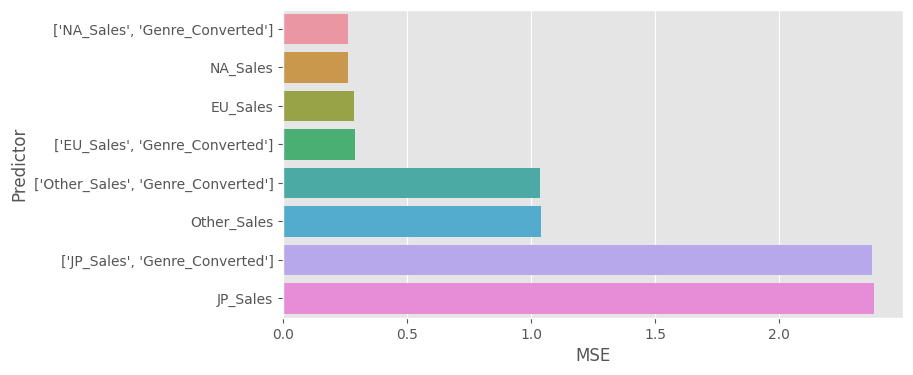

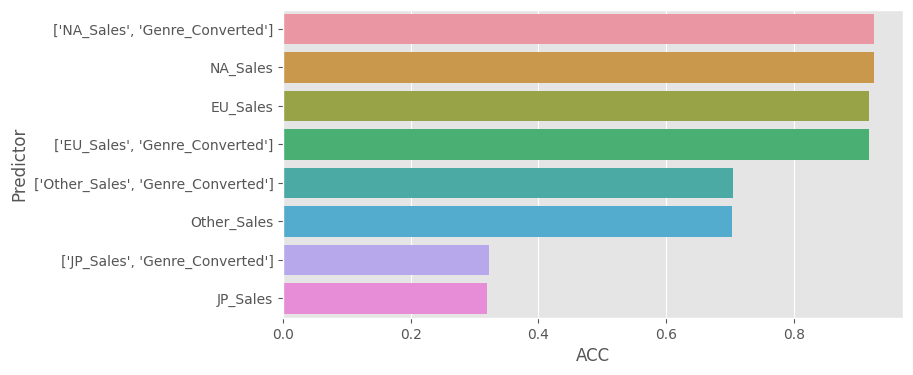

In [32]:

result_listx.append(reg(cleaned_data,sales, ["NA_Sales", "Genre_Converted"]))

result_listx.append(reg(cleaned_data,sales, ["EU_Sales", "Genre_Converted"]))

result_listx.append(reg(cleaned_data,sales, ["JP_Sales", "Genre_Converted"]))

result_listx.append(reg(cleaned_data,sales, ["Other_Sales", "Genre_Converted"]))

acc_df = pd.DataFrame(result_listx, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')

fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)

Intercept of Regression 	: b =  [0.07490419]
Coefficients of Regression 	: a =  [[1.2769364  0.00150367]]

For predictor ['NA_Sales', 'Genre_Converted']:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6506833674066992
Mean Squared Error (MSE) 	: 0.02020910712252112

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6485150739327186
Mean Squared Error (MSE) 	: 0.02085343039357333

Intercept of Regression 	: b =  [0.11752519]
Coefficients of Regression 	: a =  [[1.80085305 0.00229062]]

For predictor ['EU_Sales', 'Genre_Converted']:
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.510616226066126
Mean Squared Error (MSE) 	: 0.028312448330990198

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.507839494267652
Mean Squared Error (MSE) 	: 0.029199644387568346

Intercept of Regression 	: b =  [0.18979219]
Coefficients of Regression 	: a =  [[0.63567818 0.00270628]]

For predictor ['JP_Sales', 'Genre_Converted

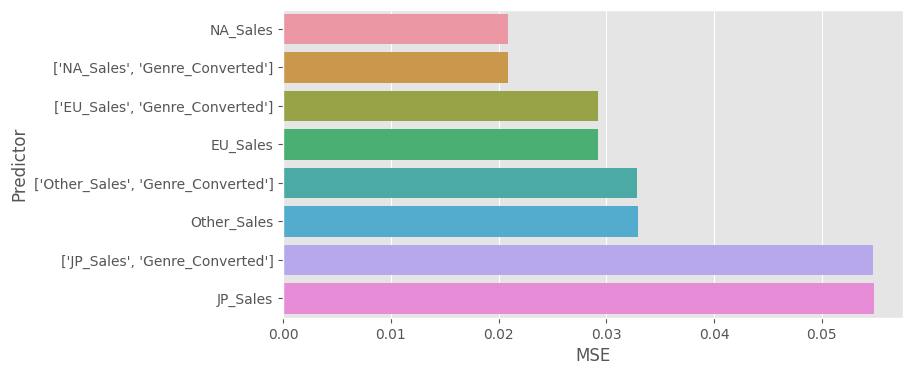

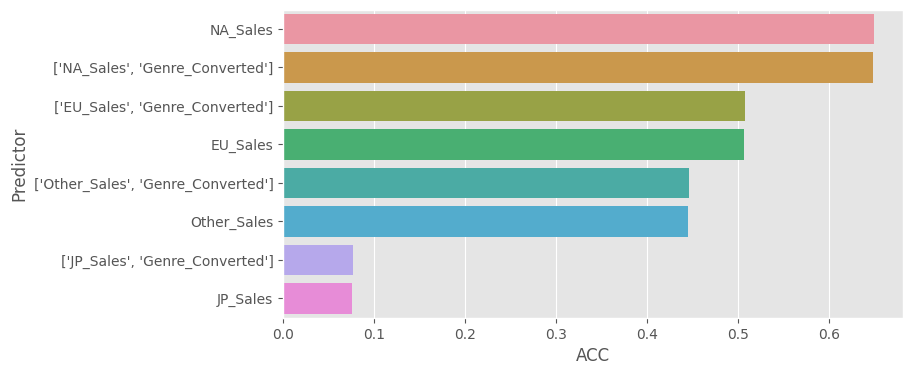

In [33]:
cleaned_data = outlier_cleaning(cleaned_data, ["Global_Sales"])
cleaned_data["Genre_Converted"] = ord_enc.fit_transform(cleaned_data[["Genre"]])
sales = pd.DataFrame(cleaned_data["Global_Sales"])

result_listc.append(reg(cleaned_data,sales, ["NA_Sales", "Genre_Converted"]))

result_listc.append(reg(cleaned_data,sales, ["EU_Sales", "Genre_Converted"]))

result_listc.append(reg(cleaned_data,sales, ["JP_Sales", "Genre_Converted"]))

result_listc.append(reg(cleaned_data,sales, ["Other_Sales", "Genre_Converted"]))

acc_df = pd.DataFrame(result_listc, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')

fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)

Using a different model(gradient boosting)

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6854608718757412
Mean Squared Error (MSE) 	: 0.018661454099283065

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5522295958041514
Mean Squared Error (MSE) 	: 0.026566001167324393

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.1520430773802881
Mean Squared Error (MSE) 	: 0.05030887344287976

Cross validation:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6000608476776172
Mean Squared Error (MSE) 	: 0.0237281961645862



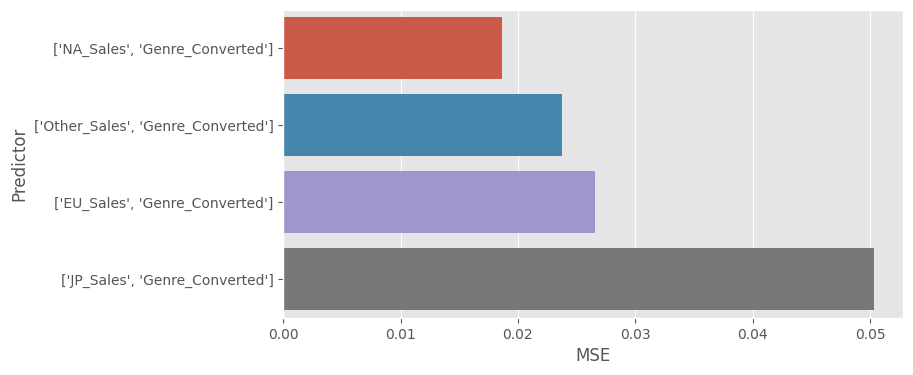

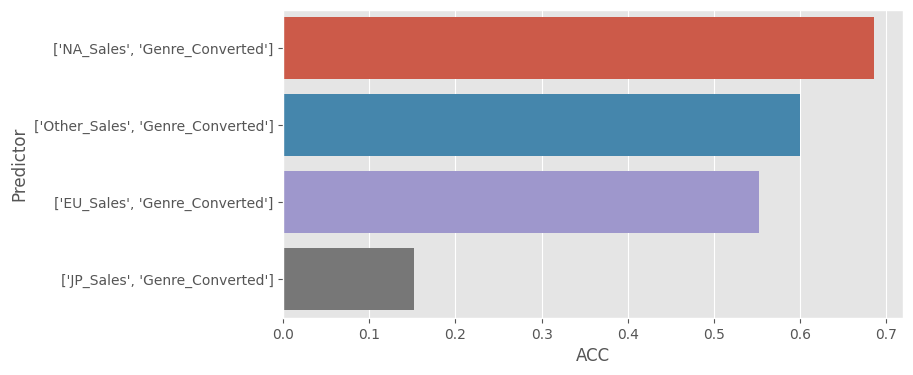

In [34]:
result_list = []
result_list.append(grad(cleaned_data, sales, ["NA_Sales", "Genre_Converted"]))
result_list.append(grad(cleaned_data, sales, ["EU_Sales", "Genre_Converted"]))
result_list.append(grad(cleaned_data, sales, ["JP_Sales", "Genre_Converted"]))
result_list.append(grad(cleaned_data, sales, ["Other_Sales", "Genre_Converted"]))

acc_df = pd.DataFrame(result_list, columns=["Predictor","ACC","MSE"]).sort_values(by='MSE')

fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="MSE", y="Predictor", data=acc_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sb.barplot(x="ACC", y="Predictor", data=acc_df)


# **Conclusion**

We realised that the variables in the dataset were not enough to predict Global sales, as there are many other factors that could affect how popular and successful a game can be. 

Take Wii sports for example, which was an innovative game that implemented real life action into video games to simulate playing the real sport. Wii sport’s success could be attributed to its innovation to not imitate other existing games, but rather create a game that was never seen before. As such, factors like creativity, constant developer updates, beta testing and such could result in a more successful game and consequently higher sales. 

With that in mind, perhaps there is more to creating a high-selling video game than just the platforms, publishers, genres and such. Instead, its success is also attributed together with the mindset of the developers to ensure the game stays relevant and innovative. 
